In [1]:
# ============================================================
# IMPORTA TODAS AS BIBLIOTECAS DO PROJETO 
# ============================================================
# ────────────────────────────────
# 1. Bibliotecas da Standard Library
# ────────────────────────────────
import gc
import hashlib
import json
import os
import random
import time
import warnings
from pathlib import Path

# ────────────────────────────────
# 2. Manipulação e análise de dados
# ────────────────────────────────
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ────────────────────────────────
# 3. Visualização
# ────────────────────────────────
import matplotlib.pyplot as plt

# ────────────────────────────────
# 4. API clients
# ────────────────────────────────
import openai

# ────────────────────────────────
# 5. Scikit-learn & pré-processamento
# ────────────────────────────────
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    balanced_accuracy_score,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    f1_score,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

# ────────────────────────────────
# 6. Imbalanced-learn
# ────────────────────────────────
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ────────────────────────────────
# 7. Modelos de gradient boosting / árvores
# ────────────────────────────────
from catboost import (
    CatBoostClassifier,
    CatBoostRegressor,
    Pool,
    cv,
    utils,
)
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# ────────────────────────────────
# 8. Deep learning
# ────────────────────────────────
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout

# ────────────────────────────────
# 9. Utilidades numéricas
# ────────────────────────────────
from numpy import arange

In [2]:
# ============================================================
# Upload dos dados na Base
# ============================================================
CSV_DIR   = Path(r"C:\dados\enem2023")
ENCODING  = "latin-1"
SEP       = ";"
ENEM_PATH = CSV_DIR / "MICRODADOS_ENEM_2023.csv"
df = pd.read_csv(ENEM_PATH, sep=SEP, encoding=ENCODING, low_memory=False)

n_rows, n_cols = df.shape
print(f"→ ENEM: {n_rows:,} linhas e {n_cols} colunas.\n")

summary_enem = (
    df.dtypes.to_frame("dtype")
      .join(df.isna().sum().to_frame("missing"))
      .reset_index()
      .rename(columns={"index": "coluna"})
      .sort_values("coluna")
)

pd.set_option("display.max_rows", None)
pd.set_option("display.width", 0)
print(summary_enem.to_string(index=False))
pd.reset_option("display.max_rows")
pd.reset_option("display.width")



→ ENEM: 3,933,955 linhas e 76 colunas.

                coluna   dtype  missing
      CO_MUNICIPIO_ESC float64  2975449
    CO_MUNICIPIO_PROVA   int64        0
           CO_PROVA_CH float64  1111312
           CO_PROVA_CN float64  1241528
           CO_PROVA_LC float64  1111312
           CO_PROVA_MT float64  1241528
             CO_UF_ESC float64  2975449
           CO_UF_PROVA   int64        0
          IN_TREINEIRO   int64        0
      NO_MUNICIPIO_ESC  object  2975449
    NO_MUNICIPIO_PROVA  object        0
                NU_ANO   int64        0
          NU_INSCRICAO   int64        0
            NU_NOTA_CH float64  1111312
            NU_NOTA_CN float64  1241528
         NU_NOTA_COMP1 float64  1111312
         NU_NOTA_COMP2 float64  1111312
         NU_NOTA_COMP3 float64  1111312
         NU_NOTA_COMP4 float64  1111312
         NU_NOTA_COMP5 float64  1111312
            NU_NOTA_LC float64  1111312
            NU_NOTA_MT float64  1241528
       NU_NOTA_REDACAO float64  1111312


In [25]:
#Fluxo Alternativo alternativo DF_COM_EMBEDDINGS
df = pd.read_parquet('df_completo_oa256_FINAL.parquet')

In [3]:
# =============================================================================
# 1. Cria coluna de média e remove:
#    • quem faltou a qualquer prova
#    • quem não tem redação válida
#    • quem é treineiro (IN_TREINEIRO == 1)
# =============================================================================


n_inicial = len(df)
print(f"Linhas originais: {n_inicial:,}")

colunas_presenca = [
    "TP_PRESENCA_CN",
    "TP_PRESENCA_CH",
    "TP_PRESENCA_LC",
    "TP_PRESENCA_MT",
    "TP_STATUS_REDACAO",
    "IN_TREINEIRO",
]

# Aplica o filtro coluna a coluna
for col in colunas_presenca:
    antes = len(df)

    if col == "IN_TREINEIRO":
        # Remove apenas quem é treineiro (valor 1)
        df = df[df[col] != 1]
        removidos = antes - len(df)
        print(f"Removidos por {col} == 1: {removidos:,}")
    else:
        # Mantém apenas quem esteve presente / status 1
        df = df[df[col] == 1]
        removidos = antes - len(df)
        print(f"Removidos por {col} != 1: {removidos:,}")
        
df['media'] = df[['NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_MT']].mean(axis=1)
media_enem2023 = df['media'].mean()
print(media_enem2023)

# Cria coluna booleana
df["abaixo_da_media"] = df["media"] < 522.05   # dtype: bool, True = em risco, False = ok

# ---------- Resultado final ----------
n_final = len(df)
print("-" * 60)
print(f"Linhas restantes após todos os filtros: {n_final:,}")
print(f"Total removido no processo: {n_inicial - n_final:,}")
print(f"Média das médias:", media_enem2023)

Linhas originais: 3,933,955
Removidos por TP_PRESENCA_CN != 1: 1,241,528
Removidos por TP_PRESENCA_CH != 1: 14,163
Removidos por TP_PRESENCA_LC != 1: 0
Removidos por TP_PRESENCA_MT != 1: 0
Removidos por TP_STATUS_REDACAO != 1: 93,149
Removidos por IN_TREINEIRO == 1: 489,141
522.058684482727
------------------------------------------------------------
Linhas restantes após todos os filtros: 2,095,974
Total removido no processo: 1,837,981
Média das médias: 522.058684482727



## Início EDA


In [4]:
# Contagem e percentual
contagem = df["abaixo_da_media"].value_counts(dropna=False).sort_index()
percent  = (contagem / len(df) * 100).round(2)

# Monta e exibe o resumo
resumo = pd.concat([
    contagem.rename("Alunos"),
    percent.rename("%")
], axis=1)

print("=== Resumo de risco (False = OK, True = em risco) ===")
print(resumo.to_string())


=== Resumo de risco (False = OK, True = em risco) ===
                  Alunos      %
abaixo_da_media                
False             993344  47.39
True             1102630  52.61


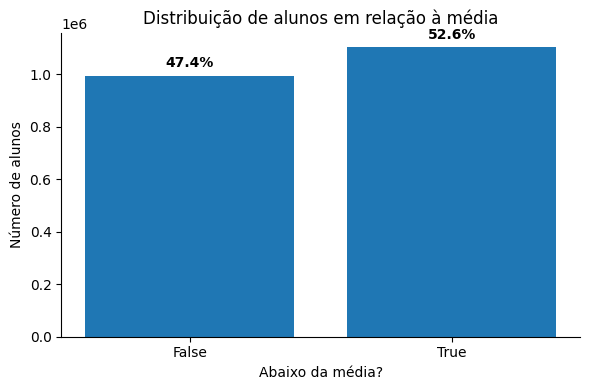

In [29]:
import matplotlib.pyplot as plt

# --- Dados (já prontos a partir do seu código) ------------------------------
#  índice: False / True
#  colunas: 'Alunos' (contagem) e '%' (percentual)
#  resumo = ...

# --- Gráfico ---------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

# barras
ax.bar(
    resumo.index.astype(str),           # False / True
    resumo["Alunos"],
)

# rótulos de percentual acima de cada barra
for i, (y, pct) in enumerate(zip(resumo["Alunos"], resumo["%"])):
    ax.text(i, y + max(resumo["Alunos"])*0.02, f"{pct:.1f}%", 
            ha="center", va="bottom", fontsize=10, fontweight="bold")

# ajustes estéticos
ax.set_title("Distribuição de alunos em relação à média")
ax.set_xlabel("Abaixo da média?")
ax.set_ylabel("Número de alunos")
ax.spines[['top', 'right']].set_visible(False)   # tira bordas sup/dir p/ ficar clean
plt.tight_layout()
plt.show()


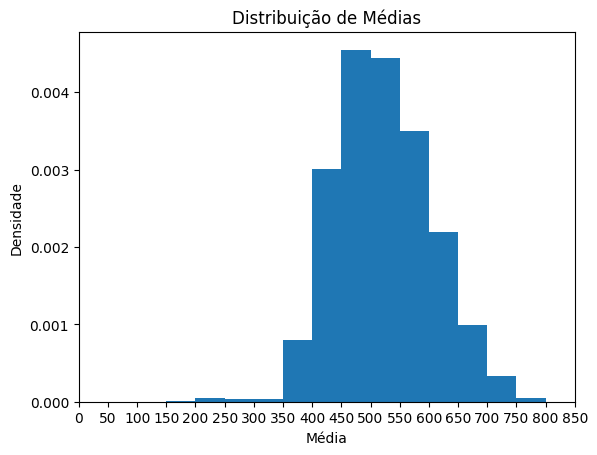

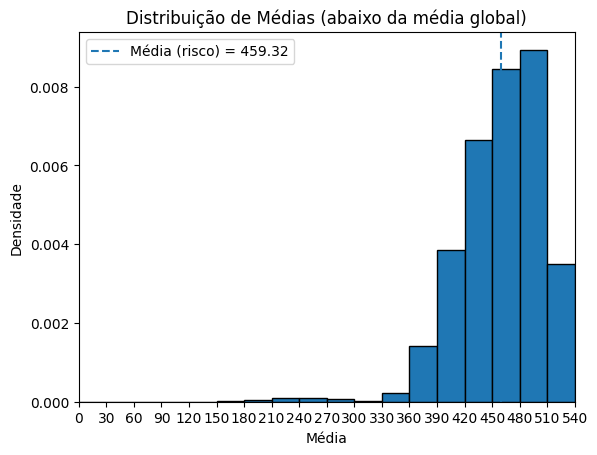


=== Resumo Numérico: Todos os Alunos ===
Total com média: 2095974 (100.00% do df)
Média:    522.06
Mediana:  516.30
Std Dev:  81.90
Mínimo:   0.00
Máximo:   833.23


In [6]:
# =============================================================================
# Visualização dos dados 
# =============================================================================
step = 50
min_m = df["media"].min()
max_m = df["media"].max()
bins = np.arange(
    start=np.floor(min_m/step)*step,
    stop=np.ceil(max_m/step)*step + step,
    step=step
)

# 1) Distribuição geral das médias
plt.figure()
plt.hist(df["media"].dropna(), bins=bins, density=True)
plt.title("Distribuição de Médias")
plt.xlabel("Média")
plt.ylabel("Densidade")
plt.xticks(bins)
plt.xlim(bins[0], bins[-1])

# =============================================================================
# 2) Distribuição dos alunos em risco – bins recalculados
# =============================================================================
step = 30  # mantenha o mesmo tamanho de classe, se preferir altere aqui
med_risco = df.loc[df["abaixo_da_media"] == 1, "media"].dropna()

# --- bins exclusivos para o subconjunto -------------------------------------
bin_start = np.floor(med_risco.min() / step) * step
bin_stop  = np.ceil(med_risco.max()  / step) * step     # último limite real
bins_risco = np.arange(bin_start, bin_stop + step, step)

# --- plot --------------------------------------------------------------------
plt.figure()
plt.hist(med_risco, bins=bins_risco, density=True, edgecolor="black")
mean_risco = med_risco.mean()
plt.axvline(mean_risco, linestyle="--", label=f"Média (risco) = {mean_risco:.2f}")

plt.title("Distribuição de Médias (abaixo da média global)")
plt.xlabel("Média")
plt.ylabel("Densidade")
plt.xticks(bins_risco)            # só os limites que realmente existem
plt.xlim(bin_start, bin_stop)     # eixo x termina no último bin válido
plt.legend()
plt.show()


# 4) Resumo Numérico: Todos os Alunos em df2
med_total     = df["media"].dropna()
count_total   = med_total.size
percent_total = count_total / len(df) * 100
mean_total    = med_total.mean()
median_total  = med_total.median()
std_total     = med_total.std()
min_total     = med_total.min()
max_total     = med_total.max()

print("\n=== Resumo Numérico: Todos os Alunos ===")
print(f"Total com média: {count_total} ({percent_total:.2f}% do df)")
print(f"Média:    {mean_total:.2f}")
print(f"Mediana:  {median_total:.2f}")
print(f"Std Dev:  {std_total:.2f}")
print(f"Mínimo:   {min_total:.2f}")
print(f"Máximo:   {max_total:.2f}")

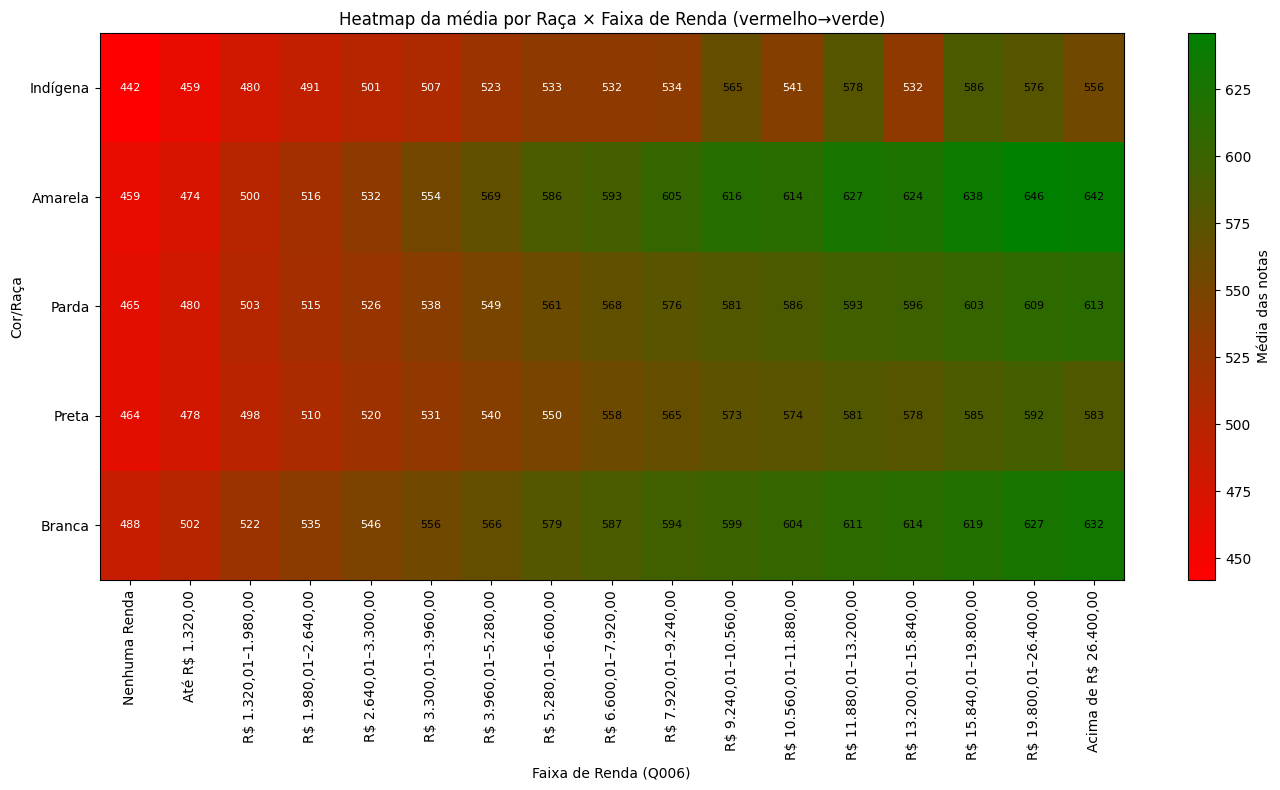

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 1) Dicionários de mapeamento direto dos códigos originais
race_map = {
    1: 'Branca',
    2: 'Preta',
    3: 'Parda',
    4: 'Amarela',
    5: 'Indígena',
}
inc_map = {
    'A': 'Nenhuma Renda',
    'B': 'Até R$ 1.320,00',
    'C': 'R$ 1.320,01–1.980,00',
    'D': 'R$ 1.980,01–2.640,00',
    'E': 'R$ 2.640,01–3.300,00',
    'F': 'R$ 3.300,01–3.960,00',
    'G': 'R$ 3.960,01–5.280,00',
    'H': 'R$ 5.280,01–6.600,00',
    'I': 'R$ 6.600,01–7.920,00',
    'J': 'R$ 7.920,01–9.240,00',
    'K': 'R$ 9.240,01–10.560,00',
    'L': 'R$ 10.560,01–11.880,00',
    'M': 'R$ 11.880,01–13.200,00',
    'N': 'R$ 13.200,01–15.840,00',
    'O': 'R$ 15.840,01–19.800,00',
    'P': 'R$ 19.800,01–26.400,00',
    'Q': 'Acima de R$ 26.400,00'
}

# 2) Cria colunas “limpas” para rótulos
df['race_label']   = df['TP_COR_RACA'].astype(int).map(race_map)
df['income_label'] = df['Q006'].map(inc_map)

# 3) Pivot table de médias
pivot = df.pivot_table(
    index='race_label',
    columns='income_label',
    values='media',
    aggfunc='mean'
)

# 4) Ordenação explícita
race_order = ['Branca','Preta','Parda','Amarela','Indígena']
inc_order  = [inc_map[k] for k in sorted(inc_map.keys())]
pivot = pivot.reindex(index=race_order, columns=inc_order)

# 5) Colormap customizado red→green
red_green = LinearSegmentedColormap.from_list('red_green', ['red','green'])

# 6) Plot do heatmap
fig, ax = plt.subplots(figsize=(14, 8))
mesh = ax.pcolormesh(
    pivot.values,
    cmap=red_green,
    shading='auto'
)
cbar = fig.colorbar(mesh, ax=ax)
cbar.set_label('Média das notas')

# 7) Ajuste de ticks no centro das células
n_rows, n_cols = pivot.shape
ax.set_xticks(np.arange(n_cols) + 0.5)
ax.set_yticks(np.arange(n_rows) + 0.5)
ax.set_xticklabels(pivot.columns, rotation=90, ha='center')
ax.set_yticklabels(pivot.index, rotation=0)

# 8) Anotação das médias em cada célula
mean_all = np.nanmean(pivot.values)
for i in range(n_rows):
    for j in range(n_cols):
        val = pivot.values[i, j]
        if not np.isnan(val):
            txt_color = 'white' if val < mean_all else 'black'
            ax.text(j + 0.5, i + 0.5, f"{val:.0f}",
                    ha='center', va='center',
                    color=txt_color, fontsize=8)

ax.set_xlabel('Faixa de Renda (Q006)')
ax.set_ylabel('Cor/Raça')
ax.set_title('Heatmap da média por Raça × Faixa de Renda (vermelho→verde)')
plt.tight_layout()
plt.show()


C:\Users\David Luz\AppData\Local\Temp\ipykernel_31720\3549276592.py:25: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
C:\Users\David Luz\AppData\Local\Temp\ipykernel_31720\3549276592.py:25: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "--s" (-> marker='s'). The keyword argument will take precedence.
  ax.errorbar(


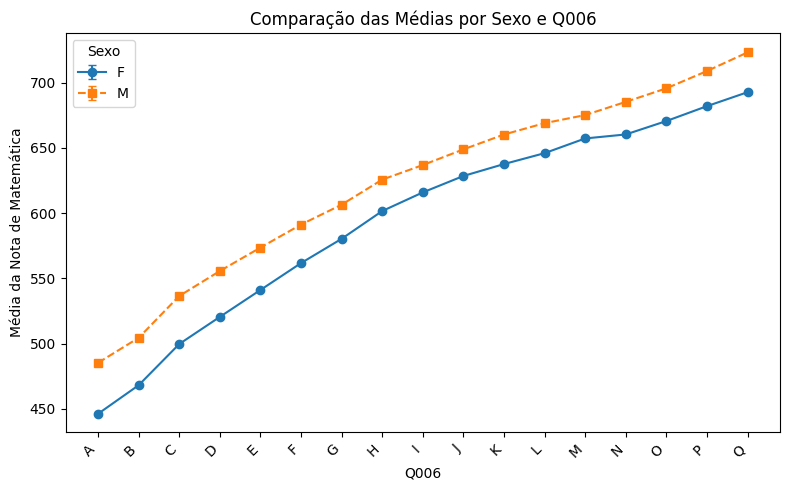

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Defina as categorias
sexos = ['F','M']
q006s  = sorted(df['Q006'].dropna().unique())

# Agregue média e sem               
agg = (
    df
    .groupby(['Q006','TP_SEXO'], observed=True)['NU_NOTA_MT']
    .agg(mean='mean', sem='sem')
    .reset_index()
)

# Prepare tabelas pivotadas  
mean_tbl = agg.pivot(index='Q006', columns='TP_SEXO', values='mean')
sem_tbl  = agg.pivot(index='Q006', columns='TP_SEXO', values='sem')

x = np.arange(len(q006s))
width = 0.0  # linhas não usam largura

fig, ax = plt.subplots(figsize=(8,5))
for sexo, fmt, marker in [('F','-o','o'), ('M','--s','s')]:
    ax.errorbar(
        x, mean_tbl[sexo], yerr=sem_tbl[sexo],
        fmt=fmt, marker=marker, label=sexo, capsize=3
    )

ax.set_xticks(x)
ax.set_xticklabels(q006s, rotation=45, ha='right')
ax.set_xlabel('Q006')
ax.set_ylabel('Média da Nota de Matemática')
ax.set_title('Comparação das Médias por Sexo e Q006')
ax.legend(title='Sexo')
plt.tight_layout()
plt.show()


C:\Users\David Luz\AppData\Local\Temp\ipykernel_43380\3107165032.py:33: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
C:\Users\David Luz\AppData\Local\Temp\ipykernel_43380\3107165032.py:33: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "--s" (-> marker='s'). The keyword argument will take precedence.
  ax.errorbar(
C:\Users\David Luz\AppData\Local\Temp\ipykernel_43380\3107165032.py:33: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
C:\Users\David Luz\AppData\Local\Temp\ipykernel_43380\3107165032.py:33: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "--s" (-> marker='s'). The keyword argument will take precedence.
  ax.errorbar(
C:\Users\D

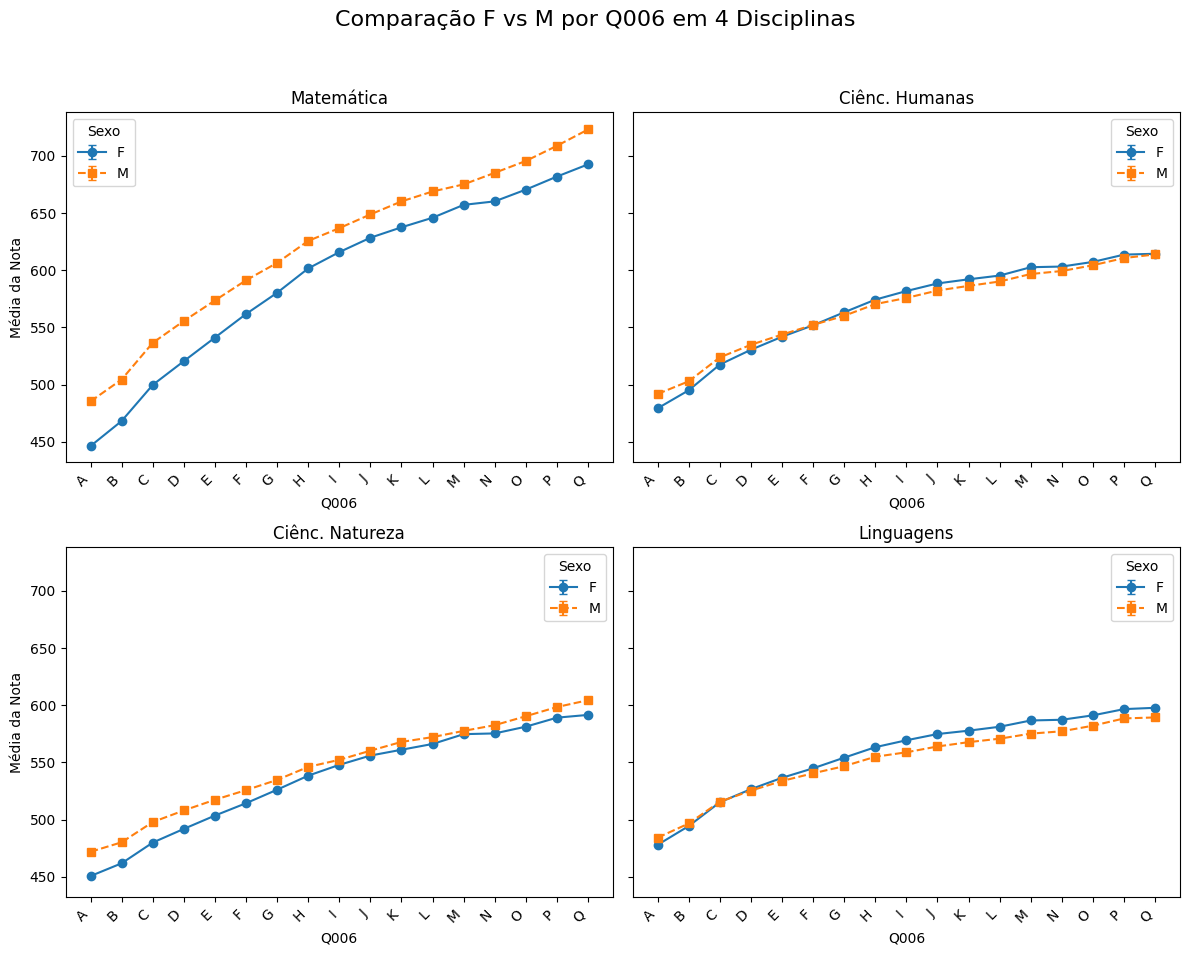

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Defina as categorias fixas
sexos = ['F','M']
q006s = sorted(df['Q006'].dropna().unique())

# 2) Liste as disciplinas que você quer plotar:
subjects = [
    ('Matemática', 'NU_NOTA_MT'),
    ('Ciênc. Humanas', 'NU_NOTA_CH'),
    ('Ciênc. Natureza', 'NU_NOTA_CN'),
    ('Linguagens',     'NU_NOTA_LC')
]

# 3) Crie o grid 2x2, compartilhando eixos Y para fácil comparação
fig, axes = plt.subplots(2, 2, figsize=(12,10), sharey=True)

for ax, (title, var) in zip(axes.flat, subjects):
    # 3.1) Agregue média e sem por Q006 e Sexo
    agg = (
        df
        .groupby(['Q006','TP_SEXO'], observed=True)[var]
        .agg(mean='mean', sem='sem')
        .reset_index()
    )
    mean_tbl = agg.pivot(index='Q006', columns='TP_SEXO', values='mean')
    sem_tbl  = agg.pivot(index='Q006', columns='TP_SEXO', values='sem')

    x = np.arange(len(q006s))
    # 3.2) Plote as duas linhas (F e M) com barras de erro
    for sexo, fmt, marker in [('F','-o','o'), ('M','--s','s')]:
        ax.errorbar(
            x, mean_tbl[sexo], yerr=sem_tbl[sexo],
            fmt=fmt, marker=marker, capsize=3, label=sexo
        )

    # 3.3) Ajustes de layout do subplot
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(q006s, rotation=45, ha='right')
    ax.set_xlabel('Q006')
    ax.legend(title='Sexo')

# 4) Rótulo geral e ajustes finais
axes[0,0].set_ylabel('Média da Nota')
axes[1,0].set_ylabel('Média da Nota')
fig.suptitle('Comparação F vs M por Q006 em 4 Disciplinas', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# ============================================================
# Fim do EDA
# ============================================================

# ============================================================
# Seleção de variáveis do Modelo
# ============================================================

In [5]:
# ============================================================
# 2. Remove colunas não utilizadas
# ============================================================

# Lista de colunas a remover
cols_to_drop = [
    # TX_GABARITO*
    "TX_GABARITO_CH",
    "TX_GABARITO_CN",
    "TX_GABARITO_LC",
    "TX_GABARITO_MT",
    # TX_RESPOSTAS*
    "TX_RESPOSTAS_CH",
    "TX_RESPOSTAS_CN",
    "TX_RESPOSTAS_LC",
    "TX_RESPOSTAS_MT",
    # NU_*
    "NU_ANO",
    "NU_INSCRICAO",
    "NU_NOTA_CH",
    "NU_NOTA_CN",
    "NU_NOTA_COMP1",
    "NU_NOTA_COMP2",
    "NU_NOTA_COMP3",
    "NU_NOTA_COMP4",
    "NU_NOTA_COMP5",
    "NU_NOTA_LC",
    "NU_NOTA_MT",
    "NU_NOTA_REDACAO",
    # CO_PROVA_*
    "CO_PROVA_CH",
    "CO_PROVA_CN",
    "CO_PROVA_LC",
    "CO_PROVA_MT",
    "CO_UF_ESC",
    # NO_MUNICIPIO_*
    "NO_MUNICIPIO_ESC",
    "CO_MUNICIPIO_ESC",
    "NO_MUNICIPIO_PROVA",
    "SG_UF_ESC",
    "TP_DEPENDENCIA_ADM_ESC",
    "TP_ENSINO",
    "TP_LOCALIZACAO_ESC",
    "TP_SIT_FUNC_ESC",
    "TP_STATUS_REDACAO",
     "TP_PRESENCA_CN",
    "TP_PRESENCA_CH",
    "TP_PRESENCA_LC",
    "TP_PRESENCA_MT",
    "TP_STATUS_REDACAO"
    "CO_UF_PROVA",
    "SG_UF_PROVA",
    "IN_TREINEIRO",
    
]

# Remove as colunas (ignora colunas faltantes sem erro)
df = df.drop(columns=cols_to_drop, errors='ignore')

In [6]:
# ============================================================
# Cria colunas UF/Município
# ============================================================

# 1) Garante que seja string de 7 dígitos (com zeros à esquerda)
df['CO_MUNICIPIO_PROVA'] = df['CO_MUNICIPIO_PROVA'].astype(str).str.zfill(7)

# 2) Extrai cada parte e já define como category
df['Regiao'] = (
    df['CO_MUNICIPIO_PROVA']
      .str[0]                  # 1º dígito
      .astype('category')
)
df['UF'] = (
    df['CO_MUNICIPIO_PROVA']
      .str[:2]                 # 1º+2º dígitos
      .astype('category')
)
df['Municipio'] = (
    df['CO_MUNICIPIO_PROVA']
      .str[2:6]                # 3º,4º,5º,6º dígitos
      .astype('category')
)

# Verificação rápida
print(df[['CO_MUNICIPIO_PROVA','Regiao','UF','Municipio']].dtypes)
print(df[['CO_MUNICIPIO_PROVA','Regiao','UF','Municipio']].head())
df['CO_MUNICIPIO_PROVA'] = df['CO_MUNICIPIO_PROVA'].astype('category')


CO_MUNICIPIO_PROVA      object
Regiao                category
UF                    category
Municipio             category
dtype: object
   CO_MUNICIPIO_PROVA Regiao  UF Municipio
2             4305108      4  43      0510
3             2304400      2  23      0440
4             2311306      2  23      1130
9             3505906      3  35      0590
10            2408102      2  24      0810


In [7]:
# ===============================================================
# Cria duas variáveis:
#   • renda_per_capita         → renda da família ÷ nº de moradores
#   • computador_por_pessoa    → computadores ÷ nº de moradores
# ===============================================================
import numpy as np
import pandas as pd

# ---------- 1. Dicionários de mapeamento -------------------------------------
map_q006_mid = {      # ponto médio (em R$) de cada faixa de Q006
    "A":      0,
    "B":    660,  "C":   1650,  "D":   2310,  "E":   2970,
    "F":   3480,  "G":   4620,  "H":   5940,  "I":   7260,
    "J":   8580,  "K":   9900,  "L":  11220,  "M":  12540,
    "N":  14520,  "O":  17820,  "P":  23100,  "Q":  30000  # escolha p/ >26 400
}
map_q024 = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4}        # “4 ou mais”

# ---------- 2. Função auxiliar para converter categorias ---------------------
def map_categorical(series: pd.Series, mapping: dict) -> pd.Series:
    """Garante string → aplica dict → devolve Float64 com suporte a NA."""
    return (
        series.astype("string")
              .str.strip()
              .str.upper()
              .map(mapping)
              .astype("Float64")
    )

# ---------- 3. Conversão das três colunas de entrada -------------------------
df["renda"]      = map_categorical(df["Q006"], map_q006_mid)
df["computador"] = map_categorical(df["Q024"], map_q024)
df["pessoas"]    = pd.to_numeric(df["Q005"], errors="coerce").astype("Float64")

# ---------- 4. Features finais (somente as pedidas) --------------------------
df["renda_per_capita"]      = df["renda"] / df["pessoas"]
df["computador_por_pessoa"] = df["computador"] / df["pessoas"]

# (opcional) conferência rápida
print(
    df[["renda_per_capita", "computador_por_pessoa"]].head()
      .to_string(index=False)
)


 renda_per_capita  computador_por_pessoa
            330.0                    0.0
            330.0                    0.0
            165.0                    0.0
           1740.0                    0.5
            165.0                   0.25


In [8]:
# ============================================================
# Converte colunas para categorias corretas no df ENEM
# ============================================================
category_cols = [
  "TP_FAIXA_ETARIA","TP_SEXO","TP_ESTADO_CIVIL","TP_COR_RACA",
    "TP_NACIONALIDADE","TP_ST_CONCLUSAO","TP_ANO_CONCLUIU",
    "TP_ESCOLA","TP_LINGUA","CO_MUNICIPIO_PROVA","CO_UF_PROVA",
    "Q001","Q002","Q003","Q004","Q005","Q006","Q007","Q008","Q009","Q010",
    "Q011","Q012","Q013","Q014","Q015","Q016","Q017","Q018","Q019","Q020",
    "Q021","Q022","Q023","Q024","Q025",
    "Regiao","UF"
]

df[category_cols] = df[category_cols].astype('category')
# ============================================================
# Gera e exibe summary de tipos e ausentes no df ENEM
# ============================================================
summary = (
    df.dtypes.to_frame("dtype")
      .join(df.isna().sum().to_frame("Ausentes"))
      .join((df.isna().mean() * 100).round(2).to_frame("%Ausentes"))
      .reset_index()
      .rename(columns={"index": "coluna"})
      .sort_values("coluna")
)

pd.set_option("display.max_rows", None)
pd.set_option("display.width", 0)
print(summary.to_string(index=False))
pd.reset_option("display.max_rows")
pd.reset_option("display.width")


               coluna    dtype  Ausentes  %Ausentes
   CO_MUNICIPIO_PROVA category         0        0.0
          CO_UF_PROVA category         0        0.0
            Municipio category         0        0.0
                 Q001 category         0        0.0
                 Q002 category         0        0.0
                 Q003 category         0        0.0
                 Q004 category         0        0.0
                 Q005 category         0        0.0
                 Q006 category         0        0.0
                 Q007 category         0        0.0
                 Q008 category         0        0.0
                 Q009 category         0        0.0
                 Q010 category         0        0.0
                 Q011 category         0        0.0
                 Q012 category         0        0.0
                 Q013 category         0        0.0
                 Q014 category         0        0.0
                 Q015 category         0        0.0
            

In [17]:
# ============================================================
# Gera e exibe summary de tipos e ausentes no df ENEM
# ============================================================
summary = (
    df.dtypes.to_frame("dtype")
      .join(df.isna().sum().to_frame("Ausentes"))
      .join((df.isna().mean() * 100).round(2).to_frame("%Ausentes"))
      .reset_index()
      .rename(columns={"index": "coluna"})
      .sort_values("coluna")
)

pd.set_option("display.max_rows", None)
pd.set_option("display.width", 0)
print(summary.to_string(index=False))
pd.reset_option("display.max_rows")
pd.reset_option("display.width")


               coluna    dtype  Ausentes  %Ausentes
   CO_MUNICIPIO_PROVA category         0       0.00
          CO_UF_PROVA category         0       0.00
            Municipio category         0       0.00
                 Q001 category         0       0.00
                 Q002 category         0       0.00
                 Q003 category         0       0.00
                 Q004 category         0       0.00
                 Q005 category         0       0.00
                 Q006 category         0       0.00
                 Q007 category         0       0.00
                 Q008 category         0       0.00
                 Q009 category         0       0.00
                 Q010 category         0       0.00
                 Q011 category         0       0.00
                 Q012 category         0       0.00
                 Q013 category         0       0.00
                 Q014 category         0       0.00
                 Q015 category         0       0.00
            

In [9]:
# Define o limite máximo de categorias para exibição completa
limite = 50

# Filtra as colunas categóricas
colunas_cat = df.select_dtypes(include='category').columns

# Para cada coluna categórica, imprime nome, cardinalidade e valores únicos
for col in colunas_cat:
    valores_unicos = df[col].dropna().unique()
    cardinalidade = len(valores_unicos)
    
    print(f'\n Coluna: {col}')
    print(f' Cardinalidade: {cardinalidade}')
    
    if cardinalidade <= limite:
        print(f' Valores: {", ".join(map(str, valores_unicos))}')
    else:
        print(f'Mais de {limite} categorias. Exibindo apenas os primeiros {limite}:')
        print(f' Valores (parcial): {", ".join(map(str, valores_unicos[:limite]))}')



 Coluna: TP_FAIXA_ETARIA
 Cardinalidade: 20
 Valores: 6, 2, 3, 11, 8, 7, 4, 12, 9, 5, 13, 14, 15, 17, 10, 1, 18, 16, 19, 20

 Coluna: TP_SEXO
 Cardinalidade: 2
 Valores: F, M

 Coluna: TP_ESTADO_CIVIL
 Cardinalidade: 5
 Valores: 1, 0, 3, 2, 4

 Coluna: TP_COR_RACA
 Cardinalidade: 6
 Valores: 1, 3, 2, 0, 5, 4

 Coluna: TP_NACIONALIDADE
 Cardinalidade: 5
 Valores: 1, 4, 2, 3, 0

 Coluna: TP_ST_CONCLUSAO
 Cardinalidade: 3
 Valores: 1, 2, 4

 Coluna: TP_ANO_CONCLUIU
 Cardinalidade: 18
 Valores: 0, 8, 5, 1, 7, 4, 10, 14, 6, 3, 9, 2, 17, 11, 12, 13, 16, 15

 Coluna: TP_ESCOLA
 Cardinalidade: 3
 Valores: 1, 2, 3

 Coluna: CO_MUNICIPIO_PROVA
 Cardinalidade: 1750
Mais de 50 categorias. Exibindo apenas os primeiros 50:
 Valores (parcial): 4305108, 2304400, 2311306, 3505906, 2408102, 4128005, 3550308, 2611606, 2402303, 1501402, 2109452, 4113700, 3101607, 4115200, 2109908, 5300108, 3157807, 2112209, 3106200, 1504422, 3205002, 3303203, 2910800, 2306405, 4202404, 1200401, 2613107, 2303709, 3302205,

# ============================================================
# Baselines
# ============================================================

In [18]:
# ============================================================
# Modelo DUMMY
# ============================================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)

# -----------------------------
# 1. separa X e y
# -----------------------------
TARGET = "abaixo_da_media"
X = df.drop(columns=[TARGET])
y = df[TARGET]

# -----------------------------
# 2. split estratificado
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,      # 70 % treino | 30 % teste
    stratify=y,          # mantém proporção das classes
    random_state=42
)

# -----------------------------
# 3. modelo dummy (baseline)
# -----------------------------
dummy = DummyClassifier(strategy="stratified", random_state=42)
dummy.fit(X_train, y_train)

# -----------------------------
# 4. avaliação
# -----------------------------
y_pred   = dummy.predict(X_test)
y_proba  = dummy.predict_proba(X_test)[:, 1]  # probabilidade da classe 1

bal_acc  = balanced_accuracy_score(y_test, y_pred)
roc_auc  = roc_auc_score(y_test, y_proba)

print("=== RESULTADOS DummyClassifier (aleatório) ===")
print(f"Balanced Accuracy : {bal_acc:.6f}")
print(f"ROC-AUC           : {roc_auc:.6f}\n")
print(classification_report(y_test, y_pred))

print("\nMatriz de confusão:")
print(confusion_matrix(y_test, y_pred))
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score

# 1) Dummy "uniform" (pura moeda)
uniform = DummyClassifier(strategy="uniform", random_state=42)
uniform.fit(X_train, y_train)
print("Uniform ROC-AUC:", roc_auc_score(y_test, uniform.predict_proba(X_test)[:,1]))

# 2) Dummy "most_frequent" (sempre a classe majoritária)
majority = DummyClassifier(strategy="most_frequent")
majority.fit(X_train, y_train)
print("Most-frequent BalancedAcc:", balanced_accuracy_score(y_test, majority.predict(X_test)))




=== RESULTADOS DummyClassifier (aleatório) ===
Balanced Accuracy : 0.500555
ROC-AUC           : 0.500555

              precision    recall  f1-score   support

       False       0.47      0.47      0.47    298004
        True       0.53      0.53      0.53    330789

    accuracy                           0.50    628793
   macro avg       0.50      0.50      0.50    628793
weighted avg       0.50      0.50      0.50    628793


Matriz de confusão:
[[141436 156568]
 [156629 174160]]
Uniform ROC-AUC: 0.5
Most-frequent BalancedAcc: 0.5


In [19]:
# ============================================================
# Regressão logística simples e sem Ordinalidade
# ============================================================

# =========================================
# 0. Bibliotecas
# =========================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)

# =========================================
# 0. Bibliotecas
# =========================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)

# =========================================
# 1. Dados  -------------------------------------------------------------
# Carregue o seu DataFrame na variável df
# df = pd.read_parquet('seu_arquivo.parquet')  # exemplo

TARGET = "abaixo_da_media"

categorical_cols = [
    "TP_FAIXA_ETARIA", "TP_SEXO", "TP_ESTADO_CIVIL", "TP_COR_RACA",
    "TP_NACIONALIDADE", "TP_ST_CONCLUSAO", "TP_ANO_CONCLUIU", "TP_ESCOLA",
    "CO_MUNICIPIO_PROVA", "CO_UF_PROVA", "TP_LINGUA",
    "Q001", "Q002", "Q003", "Q004", "Q005", "Q006", "Q007", "Q008", "Q009",
    "Q010", "Q011", "Q012", "Q013", "Q014", "Q015", "Q016", "Q017", "Q018",
    "Q019", "Q020", "Q021", "Q022", "Q023", "Q024", "Q025",
    "Regiao", "UF"
]

numeric_cols = ["computador_por_pessoa", "renda_per_capita", "renda"]

X = df[categorical_cols + numeric_cols]
y = df[TARGET]

# =========================================
# 2. Split estratificado
# =========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# =========================================
# 3. Pipeline de pré-processamento + modelo
# =========================================
preprocess = ColumnTransformer(
    transformers=[
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", sparse_output=True),
            categorical_cols
        ),
        (
            "num",
            StandardScaler(with_mean=False),  # mantém esparsidade
            numeric_cols
        ),
    ]
)

model = LogisticRegression(
    max_iter=500,      # aumente se aparecer warning de convergência
    n_jobs=-1,
    solver="lbfgs"
)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("clf", model),
])

# =========================================
# 4. Treino
# =========================================
pipe.fit(X_train, y_train)

# =========================================
# 5. Avaliação
# =========================================
y_pred  = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

print("=== RESULTADOS Logistic Regression ===")
print(f"Balanced Accuracy : {balanced_accuracy_score(y_test, y_pred):.6f}")
print(f"ROC-AUC           : {roc_auc_score(y_test, y_proba):.6f}\n")
print(classification_report(y_test, y_pred))
print("\nMatriz de confusão:")
print(confusion_matrix(y_test, y_pred))



=== RESULTADOS Logistic Regression ===
Balanced Accuracy : 0.728978
ROC-AUC           : 0.805363

              precision    recall  f1-score   support

       False       0.73      0.69      0.71    298004
        True       0.73      0.77      0.75    330789

    accuracy                           0.73    628793
   macro avg       0.73      0.73      0.73    628793
weighted avg       0.73      0.73      0.73    628793


Matriz de confusão:
[[205207  92797]
 [ 76296 254493]]


In [20]:
# ============================================================
# Random Forest
# ============================================================

# =========================================
# 0. Bibliotecas
# =========================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)

# =========================================
# 1. Dados --------------------------------------------------------------
# df = pd.read_parquet('seu_arquivo.parquet')  # exemplo
TARGET = "abaixo_da_media"

categorical_cols = [
    "TP_FAIXA_ETARIA", "TP_SEXO", "TP_ESTADO_CIVIL", "TP_COR_RACA",
    "TP_NACIONALIDADE", "TP_ST_CONCLUSAO", "TP_ANO_CONCLUIU", "TP_ESCOLA",
    "CO_MUNICIPIO_PROVA", "CO_UF_PROVA", "TP_LINGUA",
    "Q001", "Q002", "Q003", "Q004", "Q005", "Q006", "Q007", "Q008", "Q009",
    "Q010", "Q011", "Q012", "Q013", "Q014", "Q015", "Q016", "Q017", "Q018",
    "Q019", "Q020", "Q021", "Q022", "Q023", "Q024", "Q025",
    "Regiao", "UF"
]

numeric_cols = ["computador_por_pessoa", "renda_per_capita"]

X = df[categorical_cols + numeric_cols]
y = df[TARGET]

# =========================================
# 2. Split estratificado
# =========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# =========================================
# 3. Pipeline
# -----------------------------------------
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
         categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

model = RandomForestClassifier(
    n_estimators=100,      # menos árvores
    max_depth=15,         # limita profundidade
    min_samples_leaf=5,   # evita folhas muito pequenas
    n_jobs=-1,
    random_state=42
)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("clf", model),
])

# =========================================
# 4. Treino
# =========================================
pipe.fit(X_train, y_train)

# =========================================
# 5. Avaliação
# =========================================
y_pred  = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

print("=== RESULTADOS Random Forest (Ordinal) ===")
print(f"Balanced Accuracy : {balanced_accuracy_score(y_test, y_pred):.6f}")
print(f"ROC-AUC           : {roc_auc_score(y_test, y_proba):.6f}\n")
print(classification_report(y_test, y_pred))
print("\nMatriz de confusão:")
print(confusion_matrix(y_test, y_pred))


=== RESULTADOS Random Forest (Ordinal) ===
Balanced Accuracy : 0.724756
ROC-AUC           : 0.801440

              precision    recall  f1-score   support

       False       0.73      0.67      0.70    298004
        True       0.73      0.78      0.75    330789

    accuracy                           0.73    628793
   macro avg       0.73      0.72      0.73    628793
weighted avg       0.73      0.73      0.73    628793


Matriz de confusão:
[[200653  97351]
 [ 74034 256755]]


In [21]:
# ============================================================
# LightGBM  --CAMPEÃO DOS CAMPEÕES
# ============================================================
# =========================================
# 0. Bibliotecas
# =========================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier            # pip install lightgbm
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)

# =========================================
# 1. Dados  -------------------------------------------------------------
# Carregue o seu DataFrame na variável df
# df = pd.read_parquet('seu_arquivo.parquet')  # exemplo

TARGET = "abaixo_da_media"

categorical_cols = [
    "TP_FAIXA_ETARIA", "TP_SEXO", "TP_ESTADO_CIVIL", "TP_COR_RACA",
    "TP_NACIONALIDADE", "TP_ST_CONCLUSAO", "TP_ANO_CONCLUIU", "TP_ESCOLA",
    "CO_MUNICIPIO_PROVA", "CO_UF_PROVA", "TP_LINGUA",
    "Q001", "Q002", "Q003", "Q004", "Q005", "Q006", "Q007", "Q008", "Q009",
    "Q010", "Q011", "Q012", "Q013", "Q014", "Q015", "Q016", "Q017", "Q018",
    "Q019", "Q020", "Q021", "Q022", "Q023", "Q024", "Q025",
    "Regiao", "UF"
]

numeric_cols = ["computador_por_pessoa", "renda_per_capita"]

X = df[categorical_cols + numeric_cols]
y = df[TARGET]

# =========================================
# 2. Split estratificado
# =========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# =========================================
# 3. Pipeline (OrdinalEncoder → LightGBM)
# -----------------------------------------
preprocess = ColumnTransformer(
    transformers=[
        (
            "cat",
            OrdinalEncoder(
                handle_unknown="use_encoded_value",
                unknown_value=-1
            ),
            categorical_cols
        ),
        ("num", "passthrough", numeric_cols),
    ]
)

model = LGBMClassifier(
    objective="binary",
    n_estimators=500,      # nº de árvores (boosting rounds)
    learning_rate=0.05,
    num_leaves=31,         # bom ponto de partida (≈ 2^(max_depth))
    max_depth=-1,          # ilimitado; deixe o algoritmo escolher
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("clf", model),
])

# =========================================
# 4. Treino
# =========================================
pipe.fit(X_train, y_train)

# =========================================
# 5. Avaliação
# =========================================
y_pred  = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

print("=== RESULTADOS LightGBM ===")
print(f"Balanced Accuracy : {balanced_accuracy_score(y_test, y_pred):.6f}")
print(f"ROC-AUC           : {roc_auc_score(y_test, y_proba):.6f}\n")
print(classification_report(y_test, y_pred))
print("\nMatriz de confusão:")
print(confusion_matrix(y_test, y_pred))


[LightGBM] [Info] Number of positive: 771841, number of negative: 695340
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 1467181, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526071 -> initscore=0.104378
[LightGBM] [Info] Start training from score 0.104378


C:\Users\David Luz\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\David Luz\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


=== RESULTADOS LightGBM ===
Balanced Accuracy : 0.733280
ROC-AUC           : 0.811998

              precision    recall  f1-score   support

       False       0.74      0.69      0.71    298004
        True       0.74      0.78      0.76    330789

    accuracy                           0.74    628793
   macro avg       0.74      0.73      0.73    628793
weighted avg       0.74      0.74      0.73    628793


Matriz de confusão:
[[205807  92197]
 [ 74116 256673]]


# ============================================================
## Otimizadores de Modelo
# ============================================================

In [ ]:
# ============================================================
# 3) Otimizador do XGboost
# ============================================================
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix
import pandas as pd

# 1) Definir o classificador **sem** early stopping
xgb_base = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    tree_method="hist",    # substitui gpu_hist
    device="cuda",         # substitui predictor+gpu_id
    n_jobs=-1,             # usa todos os núcleos CPU para preprocessing
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
pipe_base = Pipeline([("preprocessor", preprocessor), ("clf", xgb_base)])

# 2) Rodar o RandomizedSearchCV **sem** passar clf__eval_set nem clf__early_stopping_rounds
search = RandomizedSearchCV(
    estimator=pipe_base,
    param_distributions=param_dist,
    n_iter=30,
    scoring=scorers,
    refit="f1_1",
    cv=2,
    verbose=2,
    n_jobs=-1,             # paraleliza busca de hiperparâmetros
    random_state=42,
    error_score="raise"    # garante que qualquer erro seja escalado imediatamente
)
search.fit(X_train, y_train)  # sem fit_params

print("Melhores params (CV):", search.best_params_)
print("Melhor f1_1 no CV:", search.best_score_)

# 3) Treinamento final do modelo **com** early stopping
best_params = {k.replace("clf__", ""): v for k, v in search.best_params_.items()}
final_clf = XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric="logloss",
    tree_method="hist",
    device="cuda",
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    early_stopping_rounds=30,
    verbosity=1
)
final_pipe = Pipeline([("preprocessor", preprocessor), ("clf", final_clf)])

final_pipe.fit(
    X_train, y_train,
    clf__eval_set=[(X_test, y_test)],
    clf__verbose=True   # você verá o progresso de árvores até o early stopping
)

# 4) Avaliação final
y_pred  = final_pipe.predict(X_test)
y_proba = final_pipe.predict_proba(X_test)[:, 1]

bal_acc = balanced_accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
report  = classification_report(y_test, y_pred, target_names=["0","1"])
cm      = confusion_matrix(y_test, y_pred)

print("\n=== RESULTADOS FINAIS ===")
print(f"Balanced Accuracy : {bal_acc:.6f}")
print(f"ROC-AUC           : {roc_auc:.6f}\n")
print(report)
print("Matriz de confusão:")
print(cm)

# Top 10 features
feat_names  = final_pipe.named_steps["preprocessor"].get_feature_names_out()
importances = final_pipe.named_steps["clf"].feature_importances_
feat_imp    = pd.Series(importances, index=feat_names)
top10       = feat_imp.abs().sort_values(ascending=False).head(10)

print("\nTop 10 features (|importance|):")
for name, imp in top10.items():
    print(f"{name:<35s} {imp:.4f}")


In [22]:
# ============================================================
# Catboost - Otimizado - Melhor desempenho
# ============================================================
import os
import warnings
import random
import joblib
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool, utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)

# ------------------------
# 1. Setup & reproducibilidade
# ------------------------
warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"      # usa GPU 0
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("GPUs detectadas:", utils.get_gpu_device_count())

# ------------------------
# 2. Dados
# ------------------------
# df = pd.read_parquet("seu_arquivo.parquet")  # ou o formato que usa
TARGET = "abaixo_da_media"

categorical_cols = [
    "TP_FAIXA_ETARIA", "TP_SEXO", "TP_ESTADO_CIVIL", "TP_COR_RACA",
    "TP_NACIONALIDADE", "TP_ST_CONCLUSAO", "TP_ANO_CONCLUIU", "TP_ESCOLA",
    "CO_MUNICIPIO_PROVA", "CO_UF_PROVA", "TP_LINGUA",
    "Q001", "Q002", "Q003", "Q004", "Q005", "Q006", "Q007", "Q008", "Q009",
    "Q010", "Q011", "Q012", "Q013", "Q014", "Q015", "Q016", "Q017", "Q018",
    "Q019", "Q020", "Q021", "Q022", "Q023", "Q024", "Q025",
    "Regiao", "UF"
]

numeric_base = ["computador_por_pessoa", "renda_per_capita", "renda"]

#embeddings = [
#    'emb_011', 'emb_016', 'emb_019', 'emb_022', 'emb_025', 'emb_026',
#    'emb_032', 'emb_037', 'emb_050', 'emb_067', 'emb_070', 'emb_077',
#    'emb_079', 'emb_081', 'emb_082', 'emb_084', 'emb_086', 'emb_093',
#    'emb_104', 'emb_107', 'emb_111', 'emb_114', 'emb_118', 'emb_120',
#    'emb_130', 'emb_132', 'emb_154', 'emb_156', 'emb_161', 'emb_162',
#    'emb_164', 'emb_165', 'emb_174', 'emb_183', 'emb_187', 'emb_190',
#    'emb_198', 'emb_204', 'emb_206', 'emb_207', 'emb_214', 'emb_218',
#    'emb_223', 'emb_224', 'emb_233', 'emb_238', 'emb_240', 'emb_242',
#    'emb_253', 'emb_254'
#]

numeric_cols = numeric_base #+ embeddings

# X e y
X = df[categorical_cols + numeric_cols]
y = df[TARGET].astype(int)        # garante 0/1

# ------------------------
# 3. Split estratificado 70–30
# ------------------------
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=SEED
)

# Índices (posições) das colunas categóricas para o CatBoost
cat_features = [X.columns.get_loc(col) for col in categorical_cols]

train_pool  = Pool(X_train, y_train, cat_features=cat_features)
valid_pool  = Pool(X_valid, y_valid, cat_features=cat_features)

# ------------------------
# 4. Hiperparâmetros (Optuna)
# ------------------------
best_params = {
    'loss_function':      'CrossEntropy',
    'iterations':         1062,
    'learning_rate':      0.08927180304353628,
    'depth':              7,
    'l2_leaf_reg':        1.5751320499779735,
    'random_strength':    0.31203728088487304,
    'border_count':       66,
    'bootstrap_type':     'Bernoulli',
    'subsample':          0.8540362888980227,
    'task_type':          'GPU',
    'devices':            '0',
    'gpu_ram_part':       1.0,
    'eval_metric':        'BalancedAccuracy',
    'early_stopping_rounds': 200,
    'verbose':            200,
    'random_seed':        SEED,
    'allow_writing_files': False
}

# ------------------------
# 5. Treino
# ------------------------
model = CatBoostClassifier(**best_params)
model.fit(train_pool, eval_set=valid_pool)

# ------------------------
# 6. Avaliação
# ------------------------
probs = model.predict_proba(valid_pool)[:, 1]
preds = (probs >= 0.5).astype(int)

print("\n=== RESULTADOS CatBoost ===")
print("Balanced Accuracy :", balanced_accuracy_score(y_valid, preds))
print("ROC-AUC           :", roc_auc_score(y_valid, probs))
print(classification_report(y_valid, preds, digits=3))
print("Matriz de confusão:\n", confusion_matrix(y_valid, preds, labels=[0, 1]))

# ------------------------
# 7. Salvando modelo
# ------------------------
joblib.dump(
    {'model': model, 'features': X.columns.tolist()},
    "catboost_final.pkl"
)
print("\nModelo salvo em catboost_final.pkl")


GPUs detectadas: 1


Default metric period is 5 because BalancedAccuracy is/are not implemented for GPU
Metric BalancedAccuracy is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.7100837	test: 0.7104222	best: 0.7104222 (0)	total: 728ms	remaining: 12m 52s
200:	learn: 0.7341569	test: 0.7341200	best: 0.7341200 (200)	total: 1m 16s	remaining: 5m 26s
400:	learn: 0.7363182	test: 0.7352666	best: 0.7353259 (398)	total: 2m 31s	remaining: 4m 9s
600:	learn: 0.7376669	test: 0.7356723	best: 0.7356723 (600)	total: 3m 44s	remaining: 2m 52s
800:	learn: 0.7387573	test: 0.7359300	best: 0.7360031 (787)	total: 4m 59s	remaining: 1m 37s
1000:	learn: 0.7397215	test: 0.7360201	best: 0.7361070 (945)	total: 6m 13s	remaining: 22.8s
1061:	learn: 0.7399119	test: 0.7360535	best: 0.7361070 (945)	total: 6m 37s	remaining: 0us
bestTest = 0.7361070119
bestIteration = 945
Shrink model to first 946 iterations.

=== RESULTADOS CatBoost ===
Balanced Accuracy : 0.7361070118897806
ROC-AUC           : 0.8155918721735974
              precision    recall  f1-score   support

           0      0.737     0.696     0.716    298004
           1      0.739     0.776     0.757    330789

    accura

In [24]:
# ============================================================
# XGBClassifier Otimizado
# ============================================================

import logging
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

# -------------------------------
# CONFIGURAÇÃO DE LOGGING
# -------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S"
)
logger = logging.getLogger(__name__)

# -------------------------------
# 1) CARREGA DADOS
# -------------------------------
# df = pd.read_csv("seu_dataset.csv")
feature_cols = [
    "TP_FAIXA_ETARIA","TP_SEXO","TP_ESTADO_CIVIL","TP_COR_RACA","TP_NACIONALIDADE",
    "TP_ST_CONCLUSAO","TP_ANO_CONCLUIU","TP_ESCOLA","TP_LINGUA","CO_UF_PROVA",
    *[f"Q{str(i).zfill(3)}" for i in range(1,26)],
    "Regiao","UF","renda_per_capita","computador_por_pessoa"
]
X = df[feature_cols]
y = df["abaixo_da_media"].astype(int)

# -------------------------------
# 2) SPLIT TREINO / TESTE
# -------------------------------
logger.info("Criando split treino/teste...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
logger.info(f"Train: {len(X_train)} rows, Test: {len(X_test)} rows")

# -------------------------------
# 3) PRÉ-PROCESSAMENTO
# -------------------------------
logger.info("Configurando pré-processamento...")
ord_cols = [
    "TP_FAIXA_ETARIA","TP_ESTADO_CIVIL","TP_COR_RACA","TP_NACIONALIDADE",
    "TP_ST_CONCLUSAO","TP_ANO_CONCLUIU","TP_ESCOLA",
    *[f"Q{str(i).zfill(3)}" for i in range(1,26)]
]
nom_cols = ["TP_SEXO","CO_UF_PROVA","Regiao","UF"]
num_cols = ["renda_per_capita","computador_por_pessoa"]

preprocessor = ColumnTransformer([
    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ord_cols),
    ("nom", OneHotEncoder(handle_unknown="ignore", sparse_output=False), nom_cols),
    ("num", "passthrough", num_cols),
], sparse_threshold=0)

# ajusta e transforma
preprocessor.fit(X_train)
X_train_enc = preprocessor.transform(X_train)
X_test_enc  = preprocessor.transform(X_test)

# -------------------------------
# 4) PESO DE CLASSE
# -------------------------------
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
logger.info(f"scale_pos_weight = {scale_pos_weight:.2f}")

# -------------------------------
# 5) MELHORES HYPERPARÂMETROS
# -------------------------------
best_params = {
    "subsample": 0.8,
    "n_estimators": 500,
    "min_child_weight": 5,
    "max_depth": 6,
    "learning_rate": 0.05,
    "gamma": 0,
    "colsample_bytree": 0.6
}

# -------------------------------
# 6) CLASSIFICADOR FINAL
# -------------------------------
logger.info("Treinando XGBClassifier final com early stopping...")
final_clf = XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric="logloss",
    tree_method="hist",
    device="cuda",
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    early_stopping_rounds=30,
    verbosity=1
)

final_clf.fit(
    X_train_enc, y_train,
    eval_set=[(X_test_enc, y_test)],
    verbose=True
)

# -------------------------------
# 7) AVALIAÇÃO FINAL
# -------------------------------
logger.info("Avaliação no conjunto de teste...")
y_pred  = final_clf.predict(X_test_enc)
y_proba = final_clf.predict_proba(X_test_enc)[:, 1]

bal_acc = balanced_accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
report  = classification_report(y_test, y_pred, target_names=["0","1"])
cm      = confusion_matrix(y_test, y_pred)

print("\n=== RESULTADOS FINAIS ===")
print(f"Balanced Accuracy : {bal_acc:.6f}")
print(f"ROC-AUC           : {roc_auc:.6f}\n")
print(report)
print("Matriz de confusão:")
print(cm)

# -------------------------------
# 8) TOP 10 FEATURES
# -------------------------------
feat_names  = preprocessor.get_feature_names_out()
importances = final_clf.feature_importances_
feat_imp    = pd.Series(importances, index=feat_names)
top10       = feat_imp.abs().sort_values(ascending=False).head(10)

print("\nTop 10 features (|importance|):")
for name, imp in top10.items():
    print(f"{name:<35s} {imp:.4f}")


22:30:53 [INFO] Criando split treino/teste...
22:30:55 [INFO] Train: 1467181 rows, Test: 628793 rows
22:30:55 [INFO] Configurando pré-processamento...
22:31:24 [INFO] scale_pos_weight = 0.90
22:31:24 [INFO] Treinando XGBClassifier final com early stopping...


[0]	validation_0-logloss:0.68325
[1]	validation_0-logloss:0.67422
[2]	validation_0-logloss:0.66564
[3]	validation_0-logloss:0.65754
[4]	validation_0-logloss:0.65027
[5]	validation_0-logloss:0.64388
[6]	validation_0-logloss:0.63790
[7]	validation_0-logloss:0.63193
[8]	validation_0-logloss:0.62652
[9]	validation_0-logloss:0.62207
[10]	validation_0-logloss:0.61732
[11]	validation_0-logloss:0.61303
[12]	validation_0-logloss:0.60898
[13]	validation_0-logloss:0.60546
[14]	validation_0-logloss:0.60197
[15]	validation_0-logloss:0.59900
[16]	validation_0-logloss:0.59606
[17]	validation_0-logloss:0.59336
[18]	validation_0-logloss:0.59094
[19]	validation_0-logloss:0.58874
[20]	validation_0-logloss:0.58664
[21]	validation_0-logloss:0.58462
[22]	validation_0-logloss:0.58263
[23]	validation_0-logloss:0.58077
[24]	validation_0-logloss:0.57912
[25]	validation_0-logloss:0.57762
[26]	validation_0-logloss:0.57623
[27]	validation_0-logloss:0.57486
[28]	validation_0-logloss:0.57354
[29]	validation_0-loglos

22:31:48 [INFO] Avaliação no conjunto de teste...



=== RESULTADOS FINAIS ===
Balanced Accuracy : 0.727700
ROC-AUC           : 0.805416

              precision    recall  f1-score   support

           0       0.71      0.71      0.71    298004
           1       0.74      0.74      0.74    330789

    accuracy                           0.73    628793
   macro avg       0.73      0.73      0.73    628793
weighted avg       0.73      0.73      0.73    628793

Matriz de confusão:
[[212146  85858]
 [ 84844 245945]]

Top 10 features (|importance|):
num__computador_por_pessoa          0.1345
ord__Q024                           0.1312
ord__Q006                           0.1138
num__renda_per_capita               0.0700
ord__TP_ESCOLA                      0.0261
ord__TP_COR_RACA                    0.0235
nom__Regiao_1                       0.0225
nom__TP_SEXO_F                      0.0211
ord__Q013                           0.0195
ord__Q002                           0.0195


In [47]:
# ============================================================
# Catboost Otimizado com Embeddings
# ============================================================
import os
import warnings
import random
import joblib
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool, utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)

# ------------------------
# 1. Setup & reproducibilidade
# ------------------------
warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"      # usa GPU 0
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("GPUs detectadas:", utils.get_gpu_device_count())

# ------------------------
# 2. Dados
# ------------------------
# df = pd.read_parquet("seu_arquivo.parquet")  # ou o formato que usa
TARGET = "abaixo_da_media"

categorical_cols = [
    "TP_FAIXA_ETARIA", "TP_SEXO", "TP_ESTADO_CIVIL", "TP_COR_RACA",
    "TP_NACIONALIDADE", "TP_ST_CONCLUSAO", "TP_ANO_CONCLUIU", "TP_ESCOLA",
    "CO_MUNICIPIO_PROVA", "CO_UF_PROVA", "TP_LINGUA",
    "Q001", "Q002", "Q003", "Q004", "Q005", "Q006", "Q007", "Q008", "Q009",
    "Q010", "Q011", "Q012", "Q013", "Q014", "Q015", "Q016", "Q017", "Q018",
    "Q019", "Q020", "Q021", "Q022", "Q023", "Q024", "Q025",
    "Regiao", "UF"
]

numeric_base = ["computador_por_pessoa", "renda_per_capita", "renda"]

embeddings = [
    'emb_011', 'emb_016', 'emb_019', 'emb_022', 'emb_025', 'emb_026',
    'emb_032', 'emb_037', 'emb_050', 'emb_067', 'emb_070', 'emb_077',
    'emb_079', 'emb_081', 'emb_082', 'emb_084', 'emb_086', 'emb_093',
    'emb_104', 'emb_107', 'emb_111', 'emb_114', 'emb_118', 'emb_120',
    'emb_130', 'emb_132', 'emb_154', 'emb_156', 'emb_161', 'emb_162',
    'emb_164', 'emb_165', 'emb_174', 'emb_183', 'emb_187', 'emb_190',
    'emb_198', 'emb_204', 'emb_206', 'emb_207', 'emb_214', 'emb_218',
    'emb_223', 'emb_224', 'emb_233', 'emb_238', 'emb_240', 'emb_242',
    'emb_253', 'emb_254'
]

numeric_cols = numeric_base + embeddings

# X e y
X = df[categorical_cols + numeric_cols]
y = df[TARGET].astype(int)        # garante 0/1

# ------------------------
# 3. Split estratificado 70–30
# ------------------------
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=SEED
)

# Índices (posições) das colunas categóricas para o CatBoost
cat_features = [X.columns.get_loc(col) for col in categorical_cols]

train_pool  = Pool(X_train, y_train, cat_features=cat_features)
valid_pool  = Pool(X_valid, y_valid, cat_features=cat_features)

# ------------------------
# 4. Hiperparâmetros (Optuna)
# ------------------------
best_params = {
    'loss_function':      'CrossEntropy',
    'iterations':         1062,
    'learning_rate':      0.08927180304353628,
    'depth':              7,
    'l2_leaf_reg':        1.5751320499779735,
    'random_strength':    0.31203728088487304,
    'border_count':       66,
    'bootstrap_type':     'Bernoulli',
    'subsample':          0.8540362888980227,
    'task_type':          'GPU',
    'devices':            '0',
    'gpu_ram_part':       1.0,
    'eval_metric':        'BalancedAccuracy',
    'early_stopping_rounds': 200,
    'verbose':            200,
    'random_seed':        SEED,
    'allow_writing_files': False
}

# ------------------------
# 5. Treino
# ------------------------
model = CatBoostClassifier(**best_params)
model.fit(train_pool, eval_set=valid_pool)

# ------------------------
# 6. Avaliação
# ------------------------
probs = model.predict_proba(valid_pool)[:, 1]
preds = (probs >= 0.5).astype(int)

print("\n=== RESULTADOS CatBoost ===")
print("Balanced Accuracy :", balanced_accuracy_score(y_valid, preds))
print("ROC-AUC           :", roc_auc_score(y_valid, probs))
print(classification_report(y_valid, preds, digits=3))
print("Matriz de confusão:\n", confusion_matrix(y_valid, preds, labels=[0, 1]))

# ------------------------
# 7. Salvando modelo
# ------------------------
joblib.dump(
    {'model': model, 'features': X.columns.tolist()},
    "catboost_final.pkl"
)
print("\nModelo salvo em catboost_final.pkl")


GPUs detectadas: 1


Default metric period is 5 because BalancedAccuracy is/are not implemented for GPU
Metric BalancedAccuracy is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.7086495	test: 0.7089299	best: 0.7089299 (0)	total: 741ms	remaining: 13m 5s
200:	learn: 0.7339486	test: 0.7337415	best: 0.7337415 (200)	total: 1m 24s	remaining: 6m
400:	learn: 0.7365789	test: 0.7351846	best: 0.7352670 (393)	total: 2m 52s	remaining: 4m 44s
600:	learn: 0.7383676	test: 0.7356662	best: 0.7357124 (595)	total: 4m 26s	remaining: 3m 24s
800:	learn: 0.7397805	test: 0.7358270	best: 0.7358722 (793)	total: 5m 59s	remaining: 1m 57s
1000:	learn: 0.7410326	test: 0.7357891	best: 0.7360014 (882)	total: 7m 34s	remaining: 27.7s
1061:	learn: 0.7413465	test: 0.7357571	best: 0.7360014 (882)	total: 8m 3s	remaining: 0us
bestTest = 0.7360014083
bestIteration = 882
Shrink model to first 883 iterations.

=== RESULTADOS CatBoost ===
Balanced Accuracy : 0.7360014083352648
ROC-AUC           : 0.8150411287793303
              precision    recall  f1-score   support

           0      0.737     0.695     0.716    298004
           1      0.739     0.777     0.757    330789

    accuracy   

In [46]:
# ============================================================
# XGBClassifier Otimizado com Embbedings       
# ============================================================
import logging, os, random, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier                            # pip install xgboost
from sklearn.metrics import (
    balanced_accuracy_score, roc_auc_score,
    classification_report, confusion_matrix
)

# -------------------------------
# 0) SETUP & LOGGING
# -------------------------------
os.environ["CUDA_VISIBLE_DEVICES"] = "0"     # usa GPU 0 se disponível
SEED = 42
np.random.seed(SEED); random.seed(SEED)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S"
)
logger = logging.getLogger(__name__)

# -------------------------------
# 1) CARREGA DADOS
# -------------------------------
# df = pd.read_parquet("seu_arquivo.parquet")  # exemplo
TARGET = "abaixo_da_media"                   # 0 / 1

categorical_cols = [
    "TP_FAIXA_ETARIA", "TP_SEXO", "TP_ESTADO_CIVIL", "TP_COR_RACA",
    "TP_NACIONALIDADE", "TP_ST_CONCLUSAO", "TP_ANO_CONCLUIU", "TP_ESCOLA",
    "CO_MUNICIPIO_PROVA", "CO_UF_PROVA", "TP_LINGUA",
    "Q001", "Q002", "Q003", "Q004", "Q005", "Q006", "Q007", "Q008", "Q009",
    "Q010", "Q011", "Q012", "Q013", "Q014", "Q015", "Q016", "Q017", "Q018",
    "Q019", "Q020", "Q021", "Q022", "Q023", "Q024", "Q025", "Regiao", "UF"
]

numeric_base = ["computador_por_pessoa", "renda_per_capita"]

embeddings = [
    'emb_011', 'emb_016', 'emb_019', 'emb_022', 'emb_025', 'emb_026',
    'emb_032', 'emb_037', 'emb_050', 'emb_067', 'emb_070', 'emb_077',
    'emb_079', 'emb_081', 'emb_082', 'emb_084', 'emb_086', 'emb_093',
    'emb_104', 'emb_107', 'emb_111', 'emb_114', 'emb_118', 'emb_120',
    'emb_130', 'emb_132', 'emb_154', 'emb_156', 'emb_161', 'emb_162',
    'emb_164', 'emb_165', 'emb_174', 'emb_183', 'emb_187', 'emb_190',
    'emb_198', 'emb_204', 'emb_206', 'emb_207', 'emb_214', 'emb_218',
    'emb_223', 'emb_224', 'emb_233', 'emb_238', 'emb_240', 'emb_242',
    'emb_253', 'emb_254'
]

numeric_cols = numeric_base + embeddings

# Feature matrix / alvo
X = df[categorical_cols + numeric_cols]
y = df[TARGET].astype(int)

# -------------------------------
# 2) SPLIT TREINO / TESTE
# -------------------------------
logger.info("Criando split treino/teste...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=SEED
)
logger.info(f"Train: {len(X_train):,} linhas | Test: {len(X_test):,} linhas")

# -------------------------------
# 3) PRÉ-PROCESSAMENTO (Ordinal)
# -------------------------------
logger.info("Codificando categorias com OrdinalEncoder...")
preprocessor = ColumnTransformer([
    ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
     categorical_cols),
    ("num", "passthrough", numeric_cols),
])

X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc  = preprocessor.transform(X_test)

# -------------------------------
# 4) PESO DE CLASSE
# -------------------------------
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
logger.info(f"scale_pos_weight = {scale_pos_weight:.3f}")

# -------------------------------
# 5) HYPERPARÂMETROS OTIMIZADOS
# -------------------------------
best_params = {
    "subsample":         0.8,
    "n_estimators":      500,
    "min_child_weight":  5,
    "max_depth":         6,
    "learning_rate":     0.05,
    "gamma":             0,
    "colsample_bytree":  0.6
}

# -------------------------------
# 6) CLASSIFICADOR FINAL
# -------------------------------
logger.info("Treinando XGBClassifier final (early stopping)...")
clf = XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric="logloss",
    tree_method="hist",          # GPU -> "gpu_hist" se quiser
    device="cuda",
    scale_pos_weight=scale_pos_weight,
    random_state=SEED,
    early_stopping_rounds=30,
    verbosity=1
)

clf.fit(
    X_train_enc, y_train,
    eval_set=[(X_test_enc, y_test)],
    verbose=True
)

# -------------------------------
# 7) AVALIAÇÃO FINAL
# -------------------------------
logger.info("Avaliação no conjunto de teste...")
y_pred  = clf.predict(X_test_enc)
y_proba = clf.predict_proba(X_test_enc)[:, 1]

print("\n=== RESULTADOS XGBoost Otimizado ===")
print(f"Balanced Accuracy : {balanced_accuracy_score(y_test, y_pred):.6f}")
print(f"ROC-AUC           : {roc_auc_score(y_test, y_proba):.6f}\n")
print(classification_report(y_test, y_pred, digits=3))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred, labels=[0, 1]))

# -------------------------------
# 8) TOP-10 FEATURES
# -------------------------------
feat_names  = preprocessor.get_feature_names_out()
importances = clf.feature_importances_
top10 = (pd.Series(importances, index=feat_names)
           .abs()
           .sort_values(ascending=False)
           .head(10))

print("\nTop-10 features por importância (|gain|):")
for name, imp in top10.items():
    print(f"{name:<35s} {imp:.4f}")


12:46:48 [INFO] Criando split treino/teste...
12:46:50 [INFO] Train: 1,467,181 linhas | Test: 628,793 linhas
12:46:50 [INFO] Codificando categorias com OrdinalEncoder...
12:47:09 [INFO] scale_pos_weight = 0.901
12:47:09 [INFO] Treinando XGBClassifier final (early stopping)...


[0]	validation_0-logloss:0.68167
[1]	validation_0-logloss:0.67138
[2]	validation_0-logloss:0.66208
[3]	validation_0-logloss:0.65391
[4]	validation_0-logloss:0.64619
[5]	validation_0-logloss:0.63930
[6]	validation_0-logloss:0.63261
[7]	validation_0-logloss:0.62641
[8]	validation_0-logloss:0.62115
[9]	validation_0-logloss:0.61603
[10]	validation_0-logloss:0.61112
[11]	validation_0-logloss:0.60661
[12]	validation_0-logloss:0.60235
[13]	validation_0-logloss:0.59871
[14]	validation_0-logloss:0.59511
[15]	validation_0-logloss:0.59193
[16]	validation_0-logloss:0.58888
[17]	validation_0-logloss:0.58610
[18]	validation_0-logloss:0.58343
[19]	validation_0-logloss:0.58095
[20]	validation_0-logloss:0.57866
[21]	validation_0-logloss:0.57657
[22]	validation_0-logloss:0.57465
[23]	validation_0-logloss:0.57276
[24]	validation_0-logloss:0.57096
[25]	validation_0-logloss:0.56931
[26]	validation_0-logloss:0.56788
[27]	validation_0-logloss:0.56647
[28]	validation_0-logloss:0.56520
[29]	validation_0-loglos

12:47:33 [INFO] Avaliação no conjunto de teste...



=== RESULTADOS XGBoost Otimizado ===
Balanced Accuracy : 0.733496
ROC-AUC           : 0.811425

              precision    recall  f1-score   support

           0      0.721     0.717     0.719    298004
           1      0.746     0.750     0.748    330789

    accuracy                          0.734    628793
   macro avg      0.734     0.733     0.734    628793
weighted avg      0.734     0.734     0.734    628793

Matriz de confusão:
 [[213798  84206]
 [ 82843 247946]]

Top-10 features por importância (|gain|):
num__renda                          0.1814
num__renda_per_capita               0.1488
cat__Q006                           0.1292
cat__TP_LINGUA                      0.0991
num__computador_por_pessoa          0.0884
cat__Q024                           0.0613
num__emb_084                        0.0235
num__emb_233                        0.0140
cat__TP_ESCOLA                      0.0134
cat__Q013                           0.0128


In [21]:
# ============================================================
# Adiciona coluna com descrição textual
# ============================================================

import pandas as pd

def adiciona_semantica(row):
    frases = []

    # Perfil de extrema vulnerabilidade
    if row['Q006'] in ['A', 'B'] and row['Q024'] == 'A' and row['Q025'] == 'A':
        frases.append("Vulnerabilidade econômica e tecnológica.")

    # Família grande com baixa renda
    if int(row['Q005']) >= 7 and row['Q006'] in ['A', 'B', 'C']:
        frases.append("Família numerosa com recursos limitados.")

    # Alta renda e baixa escolaridade parental
    if row['Q006'] in ['N', 'O', 'P', 'Q'] and row['Q001'] in ['A', 'B', 'C', 'D'] and row['Q002'] in ['A', 'B', 'C', 'D']:
        frases.append("Alta renda com baixa escolaridade parental, situação incomum.")

    # Situação paradoxal tecnológica
    if row['Q025'] == 'B' and row['Q024'] == 'A':
        frases.append("Acesso à internet sem computador próprio, provavelmente via celular.")

    # Casa com muitas comodidades tecnológicas
    comodidades_tec = ['Q016', 'Q017', 'Q018', 'Q021', 'Q025']
    if all(row[q] != 'A' for q in comodidades_tec):
        frases.append("Casa muito bem equipada tecnologicamente.")

    # Ambiente rural ou isolado
    if row['TP_LOCALIZACAO_ESC'] == 2 and row['Q025'] == 'A':
        frases.append("Ambiente rural ou isolamento tecnológico.")

    # Ambiente urbano privilegiado
    if row['TP_LOCALIZACAO_ESC'] == 1 and row['TP_DEPENDENCIA_ADM_ESC'] == 4 and row['Q006'] in ['K', 'L', 'M', 'N', 'O', 'P', 'Q']:
        frases.append("Estudante urbano com situação econômica confortável.")

    # Família sem veículos
    if row['Q010'] == 'A' and row['Q011'] == 'A':
        frases.append("Sem veículos, dificuldade de mobilidade.")

    # Alta dependência de motocicletas
    if row['Q011'] in ['C', 'D', 'E']:
        frases.append("Família com múltiplas motocicletas, possível atividade econômica associada.")

    # Empregada doméstica frequente com baixa renda
    if row['Q007'] in ['C', 'D'] and row['Q006'] in ['A', 'B', 'C']:
        frases.append("Alta frequência de empregada doméstica declarada com baixa renda, potencial inconsistência.")

    # Baixa escolaridade parental sem internet
    if row['Q001'] in ['A', 'B'] and row['Q002'] in ['A', 'B'] and row['Q025'] == 'A':
        frases.append("Pais sem escolaridade formal e sem acesso digital em casa.")

    # Alta escolaridade parental e tecnológica
    if row['Q001'] in ['F', 'G'] and row['Q002'] in ['F', 'G'] and row['Q024'] != 'A' and row['Q025'] != 'A':
        frases.append("Família com alta escolaridade e bem equipada tecnologicamente.")

    # Grande número de eletrodomésticos
    eletrodomesticos = ['Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017']
    qtde_eletro = sum(row[q] not in ['A', 'B'] for q in eletrodomesticos)
    if qtde_eletro >= 4:
        frases.append("Residência com muitos eletrodomésticos, indicativo de boa situação econômica.")

    # Inconsistência de renda baixa com casa equipada
    bens_duraveis = ['Q016', 'Q018', 'Q021']
    if row['Q006'] in ['A', 'B', 'C'] and all(row[q] != 'A' for q in bens_duraveis):
        frases.append("Baixa renda mas residência muito bem equipada tecnologicamente.")

    # Jovem sozinho e baixa renda
    if row['Q005'] == '1' and row['Q006'] in ['A', 'B', 'C']:
        frases.append("Jovem mora sozinho com baixa renda, possível vulnerabilidade econômica.")

    # Moradia superlotada com recursos limitados
    if int(row['Q005']) > 8 and row['Q006'] in ['A', 'B', 'C', 'D']:
        frases.append("Moradia superlotada com recursos limitados.")

    # Extrema pobreza residencial
    if row['Q008'] == 'A' or row['Q009'] == 'A':
        frases.append("Residência sem banheiro ou quartos, situação extrema.")

    # Escolaridade parental desconhecida
    if row['Q001'] == 'H' or row['Q002'] == 'H':
        frases.append("Escolaridade parental desconhecida, possivelmente ambiente familiar desestruturado.")

    # Alta renda, poucos bens duráveis
    poucos_bens = ['Q010', 'Q016', 'Q021', 'Q024']
    if row['Q006'] in ['O', 'P', 'Q'] and all(row[q] == 'A' for q in poucos_bens):
        frases.append("Alta renda declarada, mas poucos bens duráveis, possível inconsistência.")

    # Jovem adulto estudando tardiamente
    if row['TP_FAIXA_ETARIA'] in range(13,21) and row['TP_ST_CONCLUSAO'] == 4:
        frases.append("Adulto estudando tardiamente, situação socioeducacional atípica.")

    # Família de alta renda
    if row['Q006'] in ['O','P','Q'] and row['Q003'] in ['D','E'] and row['Q004'] in ['D','E']:
        frases.append("Família de alta renda.")

    return ' '.join(frases)

# Agora aplica a função e cria a coluna 'semantica'
df['semantica'] = df.apply(adiciona_semantica, axis=1)


In [ ]:
# 1) Garanta que não há NaN e que o dtype é string
df['semantica'] = df['semantica'].fillna('').astype(str)

# 2) Converta a coluna para uma lista de textos
texts = df['semantica'].tolist()
# texts agora é um list[str], pronto para enviar ao seu gerador de embeddings.



In [67]:
# supondo que você já tenha carregado df com as colunas emb_000…emb_N
# basta:
emb_cols = [col for col in df.columns if col.startswith('emb_')]

# confira quantas dimensões ele detectou
print(f"Encontrei {len(emb_cols)} colunas de embedding:")
print(emb_cols[:10], '…')  # mostra as 10 primeiras


Encontrei 256 colunas de embedding:
['emb_000', 'emb_001', 'emb_002', 'emb_003', 'emb_004', 'emb_005', 'emb_006', 'emb_007', 'emb_008', 'emb_009'] …


In [68]:
from sklearn.feature_selection import SelectKBest, f_classif

# lista de todas as dimensões de embedding
emb_cols = [c for c in df.columns if c.startswith('emb_')]

# matriz X_emb só com os embeddings, y com seu alvo
X_emb = df[emb_cols]
y     = df['abaixo_da_media']

# instancie o seletor para, por ex., as 50 melhores
selector = SelectKBest(score_func=f_classif, k=50)
selector.fit(X_emb, y)

# colunas selecionadas
selected_emb = [emb_cols[i] for i in selector.get_support(indices=True)]
print(f"Univariada → {len(selected_emb)} dimensões selecionadas:", selected_emb)


Univariada → 50 dimensões selecionadas: ['emb_011', 'emb_016', 'emb_019', 'emb_022', 'emb_025', 'emb_026', 'emb_032', 'emb_037', 'emb_050', 'emb_067', 'emb_070', 'emb_077', 'emb_079', 'emb_081', 'emb_082', 'emb_084', 'emb_086', 'emb_093', 'emb_104', 'emb_107', 'emb_111', 'emb_114', 'emb_118', 'emb_120', 'emb_130', 'emb_132', 'emb_154', 'emb_156', 'emb_161', 'emb_162', 'emb_164', 'emb_165', 'emb_174', 'emb_183', 'emb_187', 'emb_190', 'emb_198', 'emb_204', 'emb_206', 'emb_207', 'emb_214', 'emb_218', 'emb_223', 'emb_224', 'emb_233', 'emb_238', 'emb_240', 'emb_242', 'emb_253', 'emb_254']


In [40]:
from catboost import CatBoostClassifier, Pool
import numpy as np

# use um split rápido (ou Cross-Val) para não viciar
X_tr, X_te, y_tr, y_te = train_test_split(
    df[emb_cols], df['abaixo_da_media'],
    test_size=0.2, stratify=df['abaixo_da_media'], random_state=42
)

pool_tr = Pool(X_tr, y_tr)
m = CatBoostClassifier(
    iterations=200, learning_rate=0.1,
    depth=4, verbose=False, task_type='CPU'
)
m.fit(pool_tr)

# pega importâncias
imps = m.get_feature_importance(type='FeatureImportance', data=Pool(df[emb_cols], df['abaixo_da_media']))
feat_imp = dict(zip(emb_cols, imps))

# ordena e pega top K
top_k = 50
selected_emb = sorted(feat_imp, key=lambda c: -feat_imp[c])[:top_k]
print(f"Tree-based → top {top_k} dimensões:", selected_emb)


Tree-based → top 50 dimensões: ['emb_164', 'emb_233', 'emb_019', 'emb_037', 'emb_025', 'emb_183', 'emb_254', 'emb_032', 'emb_104', 'emb_003', 'emb_028', 'emb_022', 'emb_084', 'emb_093', 'emb_150', 'emb_146', 'emb_086', 'emb_010', 'emb_181', 'emb_114', 'emb_214', 'emb_015', 'emb_193', 'emb_043', 'emb_058', 'emb_185', 'emb_127', 'emb_096', 'emb_221', 'emb_218', 'emb_234', 'emb_147', 'emb_157', 'emb_112', 'emb_052', 'emb_061', 'emb_118', 'emb_126', 'emb_088', 'emb_050', 'emb_166', 'emb_090', 'emb_011', 'emb_223', 'emb_197', 'emb_001', 'emb_215', 'emb_018', 'emb_109', 'emb_169']


In [ ]:
import os
import time
import math
import numpy as np
import pandas as pd
import openai
# ============================================================
# Gerador Embeddings 3 - API Openai - Melhor modelo até agora
# ============================================================
# ============================================================
# 1) Defina sua chave de API OpenAI
# ============================================================
openai.api_key = 'sk-'

# ============================================================
# 2) Mapas de tradução para as top features
# ============================================================
map_sexo = {"M": "Masculino", "F": "Feminino"}

map_raca = {
    0: "Não declarado", 1: "Branca", 2: "Preta",
    3: "Parda", 4: "Amarela", 5: "Indígena", 6: "Sem informação"
}

# Escolaridade mãe/pai: A→Nunca estudou, B→Não completou 4ª, …, H→Não sei
map_edu = {
    "A": "Nunca estudou",
    "B": "Não completou a 4ª série/5º ano",
    "C": "Completou a 4ª, mas não a 8ª/9ª",
    "D": "Completou a 8ª/9ª, mas não o EM",
    "E": "Completou o EM, mas não a faculdade",
    "F": "Completou faculdade, mas não pós",
    "G": "Completou pós-graduação",
    "H": "Não sei"
}

# Ocupação mãe/pai: A→Grupo1, B→Grupo2, …, F→Não sei
map_ocup = {
    "A": "Grupo 1 (rural/extrativista)",
    "B": "Grupo 2 (serviços/comércio)",
    "C": "Grupo 3 (indústria/transporte)",
    "D": "Grupo 4 (técnicos/profissionais)",
    "E": "Grupo 5 (altos escalões)",
    "F": "Não sei"
}

# Renda mensal familiar: A→Nenhuma, B→Até R$1320, …, Q→Acima de R$26.400
map_renda = {
    "A": "Nenhuma renda",
    "B": "Até R$1.320,00",
    "C": "R$1.320,01–1.980,00",
    "D": "R$1.980,01–2.640,00",
    "E": "R$2.640,01–3.300,00",
    "F": "R$3.300,01–3.960,00",
    "G": "R$3.960,01–5.280,00",
    "H": "R$5.280,01–6.600,00",
    "I": "R$6.600,01–7.920,00",
    "J": "R$7.920,01–9.240,00",
    "K": "R$9.240,01–10.560,00",
    "L": "R$10.560,01–11.880,00",
    "M": "R$11.880,01–13.200,00",
    "N": "R$13.200,01–15.840,00",
    "O": "R$15.840,01–19.800,00",
    "P": "R$19.800,01–26.400,00",
    "Q": "Acima de R$26.400,00"
}

# Sim/Não para TV por assinatura, aspirador, etc.
map_simnao = {"A": "Não", "B": "Sim"}

# Região do Brasil por código IBGE
map_regiao = {
    1: "Norte",
    2: "Nordeste",
    3: "Sudeste",
    4: "Sul",
    5: "Centro-Oeste"
}

# ============================================================
# 3) Função para montar a string de contexto (semântica)
# ============================================================
def make_semantic_text(row):
    parts = []
    parts.append(f"Sexo: {map_sexo.get(row['TP_SEXO'], 'N/I')}")
    parts.append(f"Cor/Raça: {map_raca.get(row['TP_COR_RACA'], 'N/I')}")
    parts.append(f"Renda familiar: {map_renda.get(row['Q006'], 'N/I')}")
    parts.append(f"Municipio prova: {row['CO_MUNICIPIO_PROVA']}")
    parts.append(f"Escolaridade mãe: {map_edu.get(row['Q002'], 'N/I')}")
    parts.append(f"Tipo de escola: {'Pública' if row['TP_ESCOLA']==2 else 'Privada' if row['TP_ESCOLA']==3 else 'N/I'}")
    parts.append(f"Ano conclusão EM: {row['TP_ANO_CONCLUIU']}")
    parts.append(f"Tem computador: {map_simnao.get(row['Q024'], 'N/I')}")
    parts.append(f"Ocupação pai: {map_ocup.get(row['Q003'], 'N/I')}")
    parts.append(f"Freezers: {row['Q013']}")
    parts.append(f"Computador por pessoa: {row['computador_por_pessoa']:.2f}")
    parts.append(f"Idade: faixa {row['TP_FAIXA_ETARIA']}")
    parts.append(f"TV por assinatura: {map_simnao.get(row['Q021'], 'N/I')}")
    parts.append(f"Escolaridade pai: {map_edu.get(row['Q001'], 'N/I')}")
    parts.append(f"Celulares: {row['Q022']}")
    parts.append(f"Ocupação mãe: {map_ocup.get(row['Q004'], 'N/I')}")
    parts.append(f"Região: {map_regiao.get(row['Regiao'], 'N/I')}")
    parts.append(f"UF prova: {row['CO_UF_PROVA']}")
    parts.append(f"Aspirador de pó: {map_simnao.get(row['Q018'], 'N/I')}")
    return "; ".join(parts)

# ============================================================
# 4) Preencher e limpar a coluna de texto
# ============================================================
# garante que existe e é string
df['semantica'] = df.apply(make_semantic_text, axis=1)
df['semantica'] = df['semantica'].fillna('').astype(str)

# ============================================================
# 5) Preparar batches únicos para a API
# ============================================================
unique_texts = [t for t in df['semantica'].unique() if t.strip() != ""]
text_to_idx  = {text: i for i, text in enumerate(unique_texts)}

batch_size = 64
n_texts    = len(unique_texts)
n_batches  = math.ceil(n_texts / batch_size)
embeddings = [None] * n_texts

# ============================================================
# 6) Chamar a API OpenAI em batches e medir tempo
# ============================================================
start_total = time.time()
elapsed     = 0.0

for batch_id in range(n_batches):
    i0        = batch_id * batch_size
    batch_txt = unique_texts[i0 : i0 + batch_size]

    t0   = time.time()
    resp = openai.embeddings.create(
        model      = "text-embedding-3-small",
        input      = batch_txt,
        dimensions = 256
    )
    batch_time = time.time() - t0
    elapsed   += batch_time

    for j, d in enumerate(resp.data):
        embeddings[i0 + j] = d.embedding

    avg_batch = elapsed / (batch_id + 1)
    remaining = (n_batches - (batch_id + 1)) * avg_batch
    print(f"[Batch {batch_id+1}/{n_batches}] "
          f"{len(batch_txt)} textos em {batch_time:.2f}s · "
          f"≈{remaining:.2f}s restantes")

total_time = time.time() - start_total
print(f"Tempo total: {total_time:.2f}s para {n_texts} embeddings")

# ============================================================
# 7) Mapear embeddings de volta ao DataFrame
# ============================================================
emb_array = np.array(embeddings, dtype=np.float32)
n_dims    = emb_array.shape[1]
all_emb   = np.zeros((len(df), n_dims), dtype=np.float32)

for i, txt in enumerate(df['semantica']):
    if txt.strip() == "":
        continue
    idx = text_to_idx[txt]
    all_emb[i] = emb_array[idx]

# adiciona colunas emb_000 … emb_255
for dim in range(n_dims):
    df[f"emb_{dim:03d}"] = all_emb[:, dim]

# ============================================================
# 8) Salvar resultado
# ============================================================
df.to_parquet("df_completo_oa256.parquet", index=False)
print("Embeddings gerados e DataFrame salvo com sucesso!")


In [19]:
# ============================================================
# Otimizador Catboost 2.0
# ============================================================
import os
import warnings
import random
import joblib
from collections import Counter

import numpy as np
import pandas as pd
import optuna
from catboost import CatBoostClassifier, Pool, utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import RandomOverSampler

# ---- Setup básico ----
warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("GPUs disponíveis:", utils.get_gpu_device_count())

def objective(trial):
    # Espaço de busca
    params = {
        "loss_function": "CrossEntropy",
        "task_type": "GPU",
        "devices": "0",
        "gpu_ram_part": 1.0,
        "eval_metric": "BalancedAccuracy",
        "allow_writing_files": False,
        "random_seed": SEED,
        "iterations": trial.suggest_int("iterations", 800, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 4, 8),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-1, 10.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 2.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "early_stopping_rounds": 200,
        "verbose": False,
    }

    # Ajuste extra para MVS (não usa subsample) e Bayes (adiciona bagging_temperature)
    if params["bootstrap_type"] == "MVS":
        params.pop("subsample", None)
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.01, 10.0)

    # Treino e validação
    model = CatBoostClassifier(**params)
    model.fit(
        train_pool,
        eval_set=valid_pool,
        use_best_model=True,
    )

    # Avalia Balanced Accuracy
    preds = model.predict(valid_pool)
    score = balanced_accuracy_score(valid_pool.get_label(), preds)
    return score

# ---- Cria e roda o estudo ----
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50),
)
study.optimize(objective, n_trials=50, timeout=3600)  # Até 50 trials ou 1h

# ---- Resultados ----
print("Número de trials concluídos:", len(study.trials))
print("Melhor BACC: {:.4f}".format(study.best_value))
print("Melhores parâmetros:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

# ---- Treina modelo final com os melhores hiperparâmetros ----
best_params = study.best_params
best_params.update({
    "loss_function": "CrossEntropy",
    "task_type": "GPU",
    "devices": "0",
    "gpu_ram_part": 1.0,
    "eval_metric": "BalancedAccuracy",
    "random_seed": SEED,
    "allow_writing_files": False,
    "early_stopping_rounds": 200,
    "verbose": 200,
})
final_model = CatBoostClassifier(**best_params)
final_model.fit(train_pool, eval_set=valid_pool)

# ---- Salva modelo ----
joblib.dump({"model": final_model, "features": train_pool.get_feature_names()}, "catboost_optuna_best.pkl")
print("Modelo otimizado salvo em catboost_optuna_best.pkl")


[I 2025-07-02 14:27:17,510] A new study created in memory with name: no-name-fb20d91e-e984-4c55-853c-aff2ed8b547a


GPUs disponíveis: 1


Default metric period is 5 because BalancedAccuracy is/are not implemented for GPU
Metric BalancedAccuracy is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-07-02 14:40:05,954] Trial 0 finished with value: 0.7283275579401579 and parameters: {'iterations': 1062, 'learning_rate': 0.08927180304353628, 'depth': 7, 'l2_leaf_reg': 1.5751320499779735, 'random_strength': 0.31203728088487304, 'border_count': 66, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8540362888980227}. Best is trial 0 with value: 0.7283275579401579.
Default metric period is 5 because BalancedAccuracy is/are not implemented for GPU
Metric BalancedAccuracy is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-07-02 14:48:15,924] Trial 1 finished with value: 0.72826361284559 and parameters: {'iterations': 814, 'learning_rate': 0.09330606024425668, 'depth': 8, 'l2_leaf_reg': 0.26587543983272705,

Número de trials concluídos: 7
Melhor BACC: 0.7283
Melhores parâmetros:
  iterations: 1062
  learning_rate: 0.08927180304353628
  depth: 7
  l2_leaf_reg: 1.5751320499779735
  random_strength: 0.31203728088487304
  border_count: 66
  bootstrap_type: Bernoulli
  subsample: 0.8540362888980227


Default metric period is 5 because BalancedAccuracy is/are not implemented for GPU
Metric BalancedAccuracy is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.7009023	test: 0.7003886	best: 0.7003886 (0)	total: 800ms	remaining: 14m 8s
200:	learn: 0.7270622	test: 0.7259346	best: 0.7259373 (193)	total: 1m 23s	remaining: 5m 56s
400:	learn: 0.7292920	test: 0.7274626	best: 0.7274626 (400)	total: 2m 43s	remaining: 4m 30s
600:	learn: 0.7305748	test: 0.7279052	best: 0.7279381 (585)	total: 4m 5s	remaining: 3m 8s
800:	learn: 0.7315438	test: 0.7281818	best: 0.7282123 (729)	total: 5m 26s	remaining: 1m 46s
1000:	learn: 0.7323844	test: 0.7283196	best: 0.7283335 (904)	total: 6m 46s	remaining: 24.8s
1061:	learn: 0.7326953	test: 0.7282882	best: 0.7283646 (1028)	total: 7m 12s	remaining: 0us
bestTest = 0.7283646424
bestIteration = 1028
Shrink model to first 1029 iterations.
Modelo otimizado salvo em catboost_optuna_best.pkl


GPUs detectadas pelo CatBoost: 1


Default metric period is 5 because BalancedAccuracy is/are not implemented for GPU
Metric BalancedAccuracy is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.7100837	test: 0.7104222	best: 0.7104222 (0)	total: 773ms	remaining: 13m 39s
200:	learn: 0.7340936	test: 0.7340670	best: 0.7340670 (200)	total: 1m 20s	remaining: 5m 44s
400:	learn: 0.7364075	test: 0.7353579	best: 0.7354338 (393)	total: 2m 34s	remaining: 4m 15s
600:	learn: 0.7377398	test: 0.7360146	best: 0.7360146 (600)	total: 3m 48s	remaining: 2m 55s
800:	learn: 0.7387475	test: 0.7362556	best: 0.7362769 (789)	total: 5m 1s	remaining: 1m 38s
1000:	learn: 0.7395617	test: 0.7363660	best: 0.7364041 (997)	total: 6m 13s	remaining: 22.7s
1061:	learn: 0.7398450	test: 0.7363850	best: 0.7364242 (1031)	total: 6m 35s	remaining: 0us
bestTest = 0.7364242387
bestIteration = 1031
Shrink model to first 1032 iterations.
0:	learn: 0.4145091	test: 0.4178010	best: 0.4178010 (0)	total: 381ms	remaining: 6m 44s
200:	learn: 0.4141895	test: 0.4177453	best: 0.4177453 (200)	total: 1m 6s	remaining: 4m 43s
400:	learn: 0.4138833	test: 0.4177083	best: 0.4177080 (399)	total: 2m 8s	remaining: 3m 32s
600:	lear

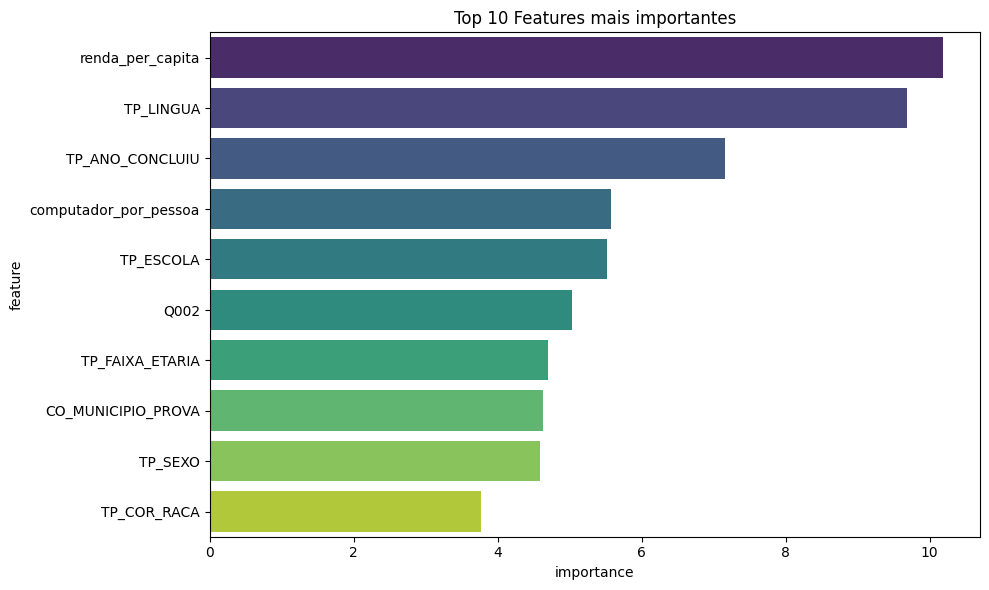

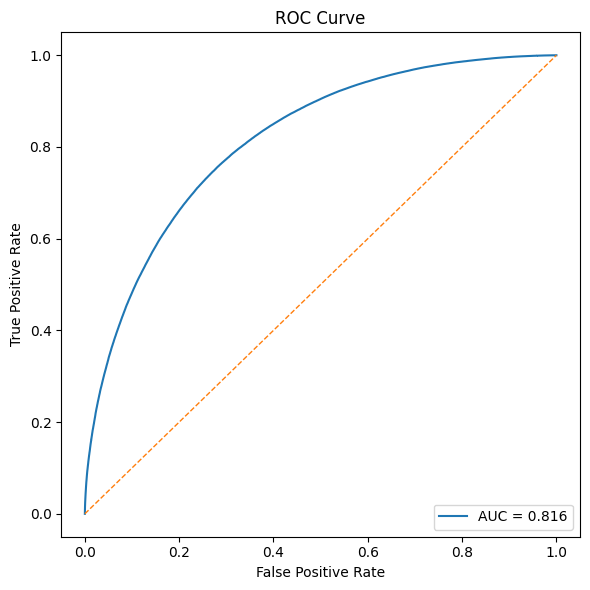

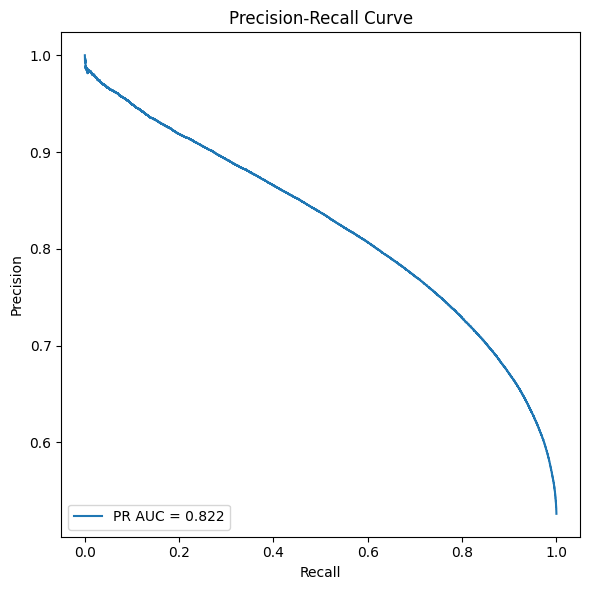

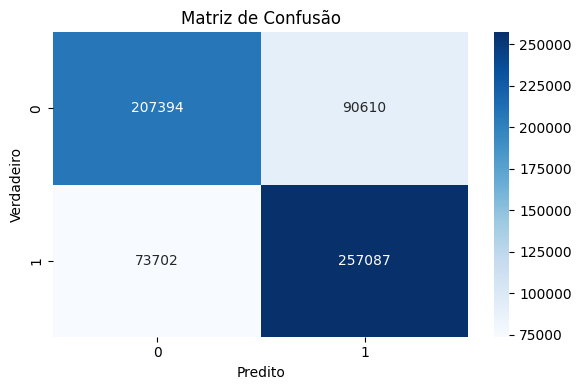


Modelos salvos em ccatboost_c_embbe.pkl
Modelos salvos em ccatboost_pipeline.pkl


In [12]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
# ============================================================
# C-CatBoost (Classifier + Regressor de Resíduos)
# Mesmo conjunto de variáveis dos demais modelos - Campeão
# ============================================================
import os
import warnings
import random
import joblib
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)

# ------------------------
# 1. Setup & reproducibilidade
# ------------------------
warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"          # usa GPU 0
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("GPUs detectadas pelo CatBoost:", utils.get_gpu_device_count())

# ------------------------
# 2. Dados
# ------------------------
# df = pd.read_parquet("seu_arquivo.parquet")     # ou o formato que já usa
TARGET = "abaixo_da_media"                        # booleano 0/1

categorical_cols = [
    "TP_FAIXA_ETARIA", "TP_SEXO", "TP_ESTADO_CIVIL", "TP_COR_RACA",
    "TP_NACIONALIDADE", "TP_ST_CONCLUSAO", "TP_ANO_CONCLUIU", "TP_ESCOLA",
    "CO_MUNICIPIO_PROVA", "CO_UF_PROVA", "TP_LINGUA",
    "Q001", "Q002", "Q003", "Q004", "Q005", "Q006", "Q007", "Q008", "Q009",
    "Q010", "Q011", "Q012", "Q013", "Q014", "Q015", "Q016", "Q017", "Q018",
    "Q019", "Q020", "Q021", "Q022", "Q023", "Q024", "Q025", "Regiao", "UF"
]

numeric_base = ["computador_por_pessoa", "renda_per_capita", "renda"]

#embeddings = [
#    'emb_011', 'emb_016', 'emb_019', 'emb_022', 'emb_025', 'emb_026',
#    'emb_032', 'emb_037', 'emb_050', 'emb_067', 'emb_070', 'emb_077',
#    'emb_079', 'emb_081', 'emb_082', 'emb_084', 'emb_086', 'emb_093',
#    'emb_104', 'emb_107', 'emb_111', 'emb_114', 'emb_118', 'emb_120',
#    'emb_130', 'emb_132', 'emb_154', 'emb_156', 'emb_161', 'emb_162',
#    'emb_164', 'emb_165', 'emb_174', 'emb_183', 'emb_187', 'emb_190',
#    'emb_198', 'emb_204', 'emb_206', 'emb_207', 'emb_214', 'emb_218',
#    'emb_223', 'emb_224', 'emb_233', 'emb_238', 'emb_240', 'emb_242',
#    'emb_253', 'emb_254'
#]

numeric_cols = numeric_base #+ embeddings

# --------------- prepara X e y
X = df[categorical_cols + numeric_cols].copy()
y = df[TARGET].astype(int).values

# garante dtype category nas categóricas (opcional, mas ajuda)
for col in categorical_cols:
    X[col] = X[col].astype("category")

cat_features = [X.columns.get_loc(c) for c in categorical_cols]

# ------------------------
# 3. Split estratificado 70-30
# ------------------------
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=SEED
)

train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
valid_pool = Pool(X_te, y_te, cat_features=cat_features)

# ------------------------
# 4. Hiperparâmetros (Optuna)
# ------------------------
best_params = {
    'loss_function': 'CrossEntropy',
    'iterations': 1062,
    'learning_rate': 0.08927180304353628,
    'depth': 7,
    'l2_leaf_reg': 1.5751320499779735,
    'random_strength': 0.31203728088487304,
    'border_count': 66,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.8540362888980227,
    'task_type': 'GPU',
    'devices': '0',
    'gpu_ram_part': 1.0,
    'eval_metric': 'BalancedAccuracy',
    'early_stopping_rounds': 200,
    'verbose': 200,
    'random_seed': SEED,
    'allow_writing_files': False
}

# ------------------------
# 5. Modelo base (Classificador)
# ------------------------
base_model = CatBoostClassifier(**best_params)
base_model.fit(train_pool, eval_set=valid_pool)

# ------------------------
# 6. Resíduos & Regressor
# ------------------------
# probas no treino / validação
p_tr_base = base_model.predict_proba(train_pool)[:, 1]
p_te_base = base_model.predict_proba(valid_pool)[:, 1]

# resíduos (label - prob)
r_tr = y_tr - p_tr_base
r_te = y_te - p_te_base

train_pool_res = Pool(X_tr, r_tr, cat_features=cat_features)
valid_pool_res = Pool(X_te, r_te, cat_features=cat_features)

reg_params = best_params.copy()
reg_params.update({
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE'
})

res_model = CatBoostRegressor(**reg_params)
res_model.fit(train_pool_res, eval_set=valid_pool_res)

# ------------------------
# 7. Combinação & Avaliação
# ------------------------
r_pred = res_model.predict(valid_pool_res)
p_final = np.clip(p_te_base + r_pred, 0, 1)
y_pred_final = (p_final >= 0.5).astype(int)

print("\n=== RESULTADOS C-CatBoost ===")
print("Balanced Accuracy :", balanced_accuracy_score(y_te, y_pred_final))
print("ROC-AUC           :", roc_auc_score(y_te, p_final))
print(classification_report(y_te, y_pred_final, digits=3))
print("Matriz de confusão:\n", confusion_matrix(y_te, y_pred_final, labels=[0, 1]))

# ------------------------
# 8. Importância de Variáveis e Métricas Adicionais
# ------------------------

# 8.1 Top 10 Features mais influentes
feature_importances = base_model.get_feature_importance(train_pool)
features = X.columns.tolist()
fi_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("\nTop 10 features mais influentes:")
print(fi_df.head(10))

# 8.2 Métricas adicionais
precision, recall, pr_thresh = precision_recall_curve(y_te, p_final)
pr_auc = auc(recall, precision)
print(f"\nÁrea Sob a Curva Precision-Recall: {pr_auc:.3f}")

ll = log_loss(y_te, p_final)
print(f"Log Loss: {ll:.3f}")

# melhor threshold para F1
f1s = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.nanargmax(f1s)
print(f"Melhor threshold p* = {pr_thresh[best_idx]:.3f} com F1 = {f1s[best_idx]:.3f}")

# ------------------------
# 9. Visualizações
# ------------------------

# 9.1 Barplot Top 10 Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=fi_df.head(10), palette='viridis')
plt.title('Top 10 Features mais importantes')
plt.tight_layout()
plt.show()

# 9.2 Curva ROC
fpr, tpr, _ = roc_curve(y_te, p_final)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_te, p_final):.3f}')
plt.plot([0,1], [0,1], '--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 9.3 Curva Precision-Recall
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# 9.4 Matriz de Confusão (heatmap)
cm = confusion_matrix(y_te, y_pred_final)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.tight_layout()
plt.show()

# ------------------------
# 10. Salvamento
# ------------------------
joblib.dump(
    {
        'base_model': base_model,
        'residual_model': res_model,
        'features': X.columns.tolist()
    },
    "ccatboost_c_embbe.pkl"
)
print("\nModelos salvos em ccatboost_c_embbe.pkl")

joblib.dump(
    {
        'base_model': base_model,
        'residual_model': res_model,
        'features': X.columns.tolist()
    },
    "ccatboost_pipeline.pkl"
)
print("Modelos salvos em ccatboost_pipeline.pkl")


GPUs detectadas pelo CatBoost: 1


Default metric period is 5 because BalancedAccuracy is/are not implemented for GPU
Metric BalancedAccuracy is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.7086495	test: 0.7089299	best: 0.7089299 (0)	total: 735ms	remaining: 13m
200:	learn: 0.7340463	test: 0.7337355	best: 0.7337599 (198)	total: 1m 23s	remaining: 5m 55s
400:	learn: 0.7366806	test: 0.7352879	best: 0.7352945 (397)	total: 2m 51s	remaining: 4m 42s
600:	learn: 0.7382618	test: 0.7357048	best: 0.7357573 (577)	total: 4m 24s	remaining: 3m 22s
800:	learn: 0.7397290	test: 0.7357229	best: 0.7357927 (634)	total: 5m 57s	remaining: 1m 56s
bestTest = 0.7357926946
bestIteration = 634
Shrink model to first 635 iterations.
0:	learn: 0.4154723	test: 0.4183415	best: 0.4183415 (0)	total: 514ms	remaining: 9m 5s
200:	learn: 0.4148438	test: 0.4181842	best: 0.4181833 (196)	total: 1m 22s	remaining: 5m 52s
400:	learn: 0.4141895	test: 0.4181347	best: 0.4181340 (396)	total: 2m 49s	remaining: 4m 40s
600:	learn: 0.4135383	test: 0.4180959	best: 0.4180959 (600)	total: 6m 28s	remaining: 4m 57s
800:	learn: 0.4129041	test: 0.4180842	best: 0.4180832 (794)	total: 10m 9s	remaining: 3m 18s
1000:	learn:

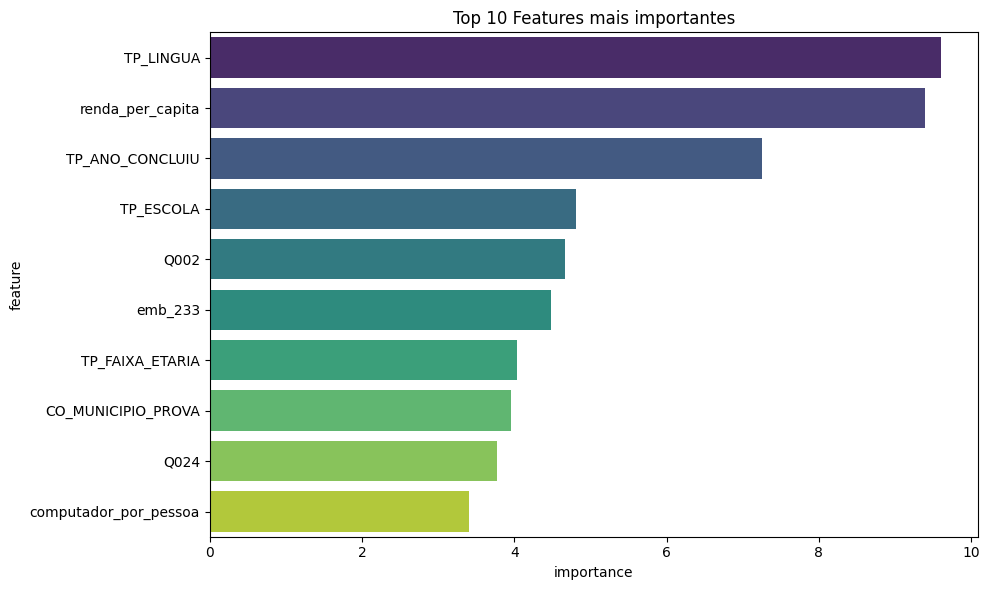

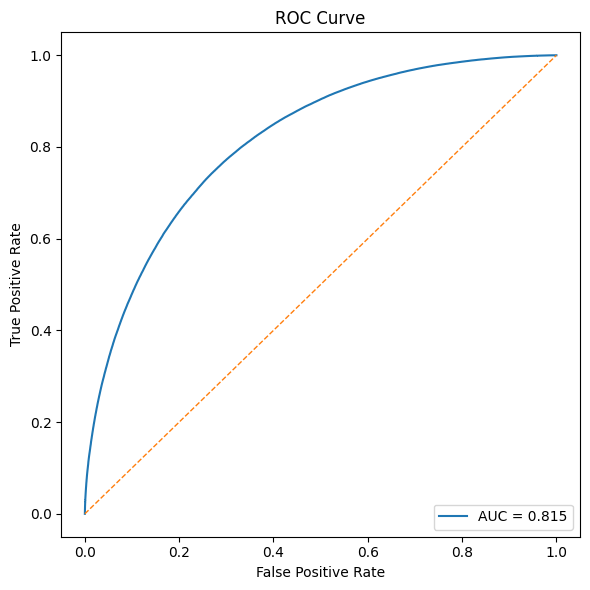

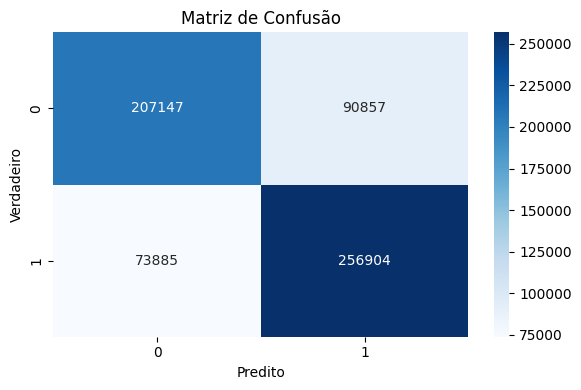


Modelos salvos em ccatboost_c_embbe.pkl


In [51]:
# ============================================================
# C-CatBoost + Embbedings
# 
# ============================================================
import os
import warnings
import random
import joblib
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc,
    log_loss,
    roc_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------
# 1. Setup & reproducibilidade
# ------------------------
warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"          # usa GPU 0
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("GPUs detectadas pelo CatBoost:", utils.get_gpu_device_count())

# ------------------------
# 2. Dados
# ------------------------
# df = pd.read_parquet("seu_arquivo.parquet")     # ou o formato que já usa
TARGET = "abaixo_da_media"                        # booleano 0/1

categorical_cols = [
    "TP_FAIXA_ETARIA", "TP_SEXO", "TP_ESTADO_CIVIL", "TP_COR_RACA",
    "TP_NACIONALIDADE", "TP_ST_CONCLUSAO", "TP_ANO_CONCLUIU", "TP_ESCOLA",
    "CO_MUNICIPIO_PROVA", "CO_UF_PROVA", "TP_LINGUA",
    "Q001", "Q002", "Q003", "Q004", "Q005", "Q006", "Q007", "Q008", "Q009",
    "Q010", "Q011", "Q012", "Q013", "Q014", "Q015", "Q016", "Q017", "Q018",
    "Q019", "Q020", "Q021", "Q022", "Q023", "Q024", "Q025", "Regiao", "UF"
]

numeric_base = ["computador_por_pessoa", "renda_per_capita", "renda"]

embeddings = [
    'emb_011', 'emb_016', 'emb_019', 'emb_022', 'emb_025', 'emb_026',
    'emb_032', 'emb_037', 'emb_050', 'emb_067', 'emb_070', 'emb_077',
    'emb_079', 'emb_081', 'emb_082', 'emb_084', 'emb_086', 'emb_093',
    'emb_104', 'emb_107', 'emb_111', 'emb_114', 'emb_118', 'emb_120',
    'emb_130', 'emb_132', 'emb_154', 'emb_156', 'emb_161', 'emb_162',
    'emb_164', 'emb_165', 'emb_174', 'emb_183', 'emb_187', 'emb_190',
    'emb_198', 'emb_204', 'emb_206', 'emb_207', 'emb_214', 'emb_218',
    'emb_223', 'emb_224', 'emb_233', 'emb_238', 'emb_240', 'emb_242',
    'emb_253', 'emb_254'
]

numeric_cols = numeric_base + embeddings

# --------------- prepara X e y
X = df[categorical_cols + numeric_cols].copy()
y = df[TARGET].astype(int).values

# garante dtype category nas categóricas
for col in categorical_cols:
    X[col] = X[col].astype("category")

cat_features = [X.columns.get_loc(c) for c in categorical_cols]

# ------------------------
# 3. Split estratificado 70-30
# ------------------------
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=SEED
)

train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
valid_pool = Pool(X_te, y_te, cat_features=cat_features)

# ------------------------
# 4. Hiperparâmetros (Optuna)
# ------------------------
best_params = {
    'loss_function': 'CrossEntropy',
    'iterations': 1062,
    'learning_rate': 0.08927180304353628,
    'depth': 7,
    'l2_leaf_reg': 1.5751320499779735,
    'random_strength': 0.31203728088487304,
    'border_count': 66,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.8540362888980227,
    'task_type': 'GPU',
    'devices': '0',
    'gpu_ram_part': 1.0,
    'eval_metric': 'BalancedAccuracy',
    'early_stopping_rounds': 200,
    'verbose': 200,
    'random_seed': SEED,
    'allow_writing_files': False
}

# ------------------------
# 5. Modelo base (Classificador)
# ------------------------
base_model = CatBoostClassifier(**best_params)
base_model.fit(train_pool, eval_set=valid_pool)

# ------------------------
# 6. Resíduos & Regressor
# ------------------------
p_tr_base = base_model.predict_proba(train_pool)[:, 1]
p_te_base = base_model.predict_proba(valid_pool)[:, 1]

r_tr = y_tr - p_tr_base
r_te = y_te - p_te_base

train_pool_res = Pool(X_tr, r_tr, cat_features=cat_features)
valid_pool_res = Pool(X_te, r_te, cat_features=cat_features)

reg_params = best_params.copy()
reg_params.update({
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE'
})

res_model = CatBoostRegressor(**reg_params)
res_model.fit(train_pool_res, eval_set=valid_pool_res)

# ------------------------
# 7. Combinação & Avaliação
# ------------------------
r_pred = res_model.predict(valid_pool_res)
p_final = np.clip(p_te_base + r_pred, 0, 1)
y_pred_final = (p_final >= 0.5).astype(int)

print("\n=== RESULTADOS C-CatBoost ===")
print("Balanced Accuracy :", balanced_accuracy_score(y_te, y_pred_final))
print("ROC-AUC           :", roc_auc_score(y_te, p_final))
print(classification_report(y_te, y_pred_final, digits=3))
print("Matriz de confusão:\n", confusion_matrix(y_te, y_pred_final, labels=[0, 1]))

# ------------------------
# 8. Importância de Variáveis e Métricas Adicionais
# ------------------------

# 8.1 Top 10 Features mais influentes
feature_importances = base_model.get_feature_importance(train_pool)
features = X.columns.tolist()
fi_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("\nTop 10 features mais influentes:")
print(fi_df.head(10))

# 8.2 Métricas adicionais
# Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_te, p_final)
pr_auc = auc(recall, precision)
print(f"\nÁrea Sob a Curva Precision-Recall: {pr_auc:.3f}")

# Log Loss
ll = log_loss(y_te, p_final)
print(f"Log Loss: {ll:.3f}")

# ------------------------
# 9. Visualizações
# ------------------------

# 9.1 Barplot Top 10 Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(
    x='importance', y='feature',
    data=fi_df.head(10),
    palette='viridis'
)
plt.title('Top 10 Features mais importantes')
plt.tight_layout()
plt.show()

# 9.2 Curva ROC
fpr, tpr, _ = roc_curve(y_te, p_final)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_te, p_final):.3f}')
plt.plot([0,1], [0,1], '--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 9.3 Matriz de Confusão (heatmap)
cm = confusion_matrix(y_te, y_pred_final)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.tight_layout()
plt.show()

# ------------------------
# 10. Salvamento
# ------------------------
joblib.dump(
    {
        'base_model': base_model,
        'residual_model': res_model,
        'features': X.columns.tolist()
    },
    "ccatboost_c_embbe.pkl"
)
print("\nModelos salvos em ccatboost_c_embbe.pkl")


In [52]:
# %% Cálculo de VIF para multicolinearidade (cole nesta célula separada)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# 1. Seleciona apenas as colunas numéricas (base + embeddings)
X_vif = X_tr[numeric_cols].copy()

# 2. Preenche valores faltantes e escala
X_vif = X_vif.fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vif)

# 3. Calcula o VIF para cada variável
vif_data = pd.DataFrame({
    'feature': X_vif.columns,
    'VIF': [variance_inflation_factor(X_scaled, i) 
            for i in range(X_scaled.shape[1])]
})

# 4. Exibe as 10 variáveis com maior VIF
print("Top 10 variáveis por VIF:")
print(vif_data.sort_values('VIF', ascending=False).head(50))


Top 10 variáveis por VIF:
    feature        VIF
48  emb_238  33.132649
23  emb_111  28.204816
26  emb_120  24.613387
46  emb_224  22.513122
51  emb_253  20.792958
30  emb_156  20.730921
42  emb_207  20.225411
5   emb_019  19.655199
49  emb_240  18.975954
29  emb_154  18.501551


In [53]:
print(vif_data.sort_values('VIF', ascending=False).head(50))

    feature        VIF
48  emb_238  33.132649
23  emb_111  28.204816
26  emb_120  24.613387
46  emb_224  22.513122
51  emb_253  20.792958
30  emb_156  20.730921
42  emb_207  20.225411
5   emb_019  19.655199
49  emb_240  18.975954
29  emb_154  18.501551
47  emb_233  17.145797
24  emb_114  16.929092
12  emb_067  15.707984
3   emb_011  15.378120
33  emb_164  15.311872
36  emb_183  14.528347
15  emb_079  14.358114
32  emb_162  13.726220
40  emb_204  13.712617
45  emb_223  13.219030
28  emb_132  13.052670
9   emb_032  12.778739
8   emb_026  12.556509
37  emb_187  12.370234
18  emb_084  11.510993
34  emb_165  11.440857
25  emb_118  11.434935
50  emb_242  11.252524
43  emb_214  10.458181
41  emb_206   9.981300
11  emb_050   9.900366
22  emb_107   9.883207
6   emb_022   9.480964
16  emb_081   9.437655
21  emb_104   9.306619
27  emb_130   9.130541
2     renda   9.125863
4   emb_016   8.947123
44  emb_218   8.786292
39  emb_198   8.634909
52  emb_254   8.398623
10  emb_037   8.067310
19  emb_086

In [45]:
# =========================================
# LIGHTGBM com Embeddings - Super campeão
# =========================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)

# =========================================
# 1. Dados --------------------------------------------------------------
# Carregue o seu DataFrame na variável df
# df = pd.read_parquet('seu_arquivo.parquet')  # exemplo

TARGET = "abaixo_da_media"

categorical_cols = [
    "TP_FAIXA_ETARIA", "TP_SEXO", "TP_ESTADO_CIVIL", "TP_COR_RACA",
    "TP_NACIONALIDADE", "TP_ST_CONCLUSAO", "TP_ANO_CONCLUIU", "TP_ESCOLA",
    "CO_MUNICIPIO_PROVA", "CO_UF_PROVA", "TP_LINGUA",
    "Q001", "Q002", "Q003", "Q004", "Q005", "Q006", "Q007", "Q008", "Q009",
    "Q010", "Q011", "Q012", "Q013", "Q014", "Q015", "Q016", "Q017", "Q018",
    "Q019", "Q020", "Q021", "Q022", "Q023", "Q024", "Q025",
    "Regiao", "UF"
]

# ---- variáveis numéricas originais
numeric_base = ["computador_por_pessoa", "renda_per_capita", "renda"]

# ---- embeddings semânticos adicionados
embeddings = [
    'emb_011', 'emb_016', 'emb_019', 'emb_022', 'emb_025', 'emb_026',
    'emb_032', 'emb_037', 'emb_050', 'emb_067', 'emb_070', 'emb_077',
    'emb_079', 'emb_081', 'emb_082', 'emb_084', 'emb_086', 'emb_093',
    'emb_104', 'emb_107', 'emb_111', 'emb_114', 'emb_118', 'emb_120',
    'emb_130', 'emb_132', 'emb_154', 'emb_156', 'emb_161', 'emb_162',
    'emb_164', 'emb_165', 'emb_174', 'emb_183', 'emb_187', 'emb_190',
    'emb_198', 'emb_204', 'emb_206', 'emb_207', 'emb_214', 'emb_218',
    'emb_223', 'emb_224', 'emb_233', 'emb_238', 'emb_240', 'emb_242',
    'emb_253', 'emb_254'
]

numeric_cols = numeric_base + embeddings

# ---- divide X e y
X = df[categorical_cols + numeric_cols]
y = df[TARGET]

# =========================================
# 2. Split estratificado
# =========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# =========================================
# 3. Pipeline (OrdinalEncoder → LightGBM)
# -----------------------------------------
preprocess = ColumnTransformer(
    transformers=[
        (
            "cat",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            categorical_cols
        ),
        ("num", "passthrough", numeric_cols),
    ]
)

model = LGBMClassifier(
    objective="binary",
    n_estimators=600,      # ligeiro aumento por conta das novas features
    learning_rate=0.04,
    num_leaves=63,        # um pouco maior para capturar interações
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("clf", model),
])

# =========================================
# 4. Treino
# =========================================
pipe.fit(X_train, y_train)

# =========================================
# 5. Avaliação
# =========================================
y_pred  = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

print("=== RESULTADOS LightGBM (com embeddings) ===")
print(f"Balanced Accuracy : {balanced_accuracy_score(y_test, y_pred):.6f}")
print(f"ROC-AUC           : {roc_auc_score(y_test, y_proba):.6f}\n")
print(classification_report(y_test, y_pred))
print("\nMatriz de confusão:")
print(confusion_matrix(y_test, y_pred))


[LightGBM] [Info] Number of positive: 771841, number of negative: 695340
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.267894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13464
[LightGBM] [Info] Number of data points in the train set: 1467181, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526071 -> initscore=0.104378
[LightGBM] [Info] Start training from score 0.104378
=== RESULTADOS LightGBM (com embeddings) ===
Balanced Accuracy : 0.733237
ROC-AUC           : 0.811870

              precision    recall  f1-score   support

       False       0.74      0.69      0.71    298004
        True       0.74      0.78      0.76    330789

    accuracy                           0.74    628793
   macro avg       0.74      0.73      0.73    628793
weighted avg       0.74      0.74      0.73    628793


Matriz de confusão:
[[205733  92271]
 [ 74062 256727]]


In [48]:
# ============================================================
#  Apenas EMBEDDINGS (para comparação isolada)
# Mesmo esqueleto e hiperparâmetros do CatBoost otimizado
# ============================================================
import os, warnings, random, joblib, numpy as np, pandas as pd
from catboost import CatBoostClassifier, Pool, utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    balanced_accuracy_score, roc_auc_score,
    classification_report, confusion_matrix
)

# ------------------------
# 1. Setup & reproducibilidade
# ------------------------
warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("GPUs detectadas:", utils.get_gpu_device_count())

# ------------------------
# 2. Dados
# ------------------------
# df = pd.read_parquet("seu_arquivo.parquet")  # ou outro formato
TARGET = "abaixo_da_media"

embeddings = [
    'emb_011', 'emb_016', 'emb_019', 'emb_022', 'emb_025', 'emb_026',
    'emb_032', 'emb_037', 'emb_050', 'emb_067', 'emb_070', 'emb_077',
    'emb_079', 'emb_081', 'emb_082', 'emb_084', 'emb_086', 'emb_093',
    'emb_104', 'emb_107', 'emb_111', 'emb_114', 'emb_118', 'emb_120',
    'emb_130', 'emb_132', 'emb_154', 'emb_156', 'emb_161', 'emb_162',
    'emb_164', 'emb_165', 'emb_174', 'emb_183', 'emb_187', 'emb_190',
    'emb_198', 'emb_204', 'emb_206', 'emb_207', 'emb_214', 'emb_218',
    'emb_223', 'emb_224', 'emb_233', 'emb_238', 'emb_240', 'emb_242',
    'emb_253', 'emb_254'
]

categorical_cols = []                 # sem variáveis categóricas
numeric_cols     = embeddings         # somente embeddings

X = df[numeric_cols]
y = df[TARGET].astype(int)

# ------------------------
# 3. Split estratificado 70–30
# ------------------------
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=SEED
)

cat_features = []                     # nenhuma coluna categórica
train_pool  = Pool(X_train, y_train, cat_features=cat_features)
valid_pool  = Pool(X_valid, y_valid, cat_features=cat_features)

# ------------------------
# 4. Hiperparâmetros (os mesmos)
# ------------------------
best_params = {
    'loss_function':      'CrossEntropy',
    'iterations':         1062,
    'learning_rate':      0.08927180304353628,
    'depth':              7,
    'l2_leaf_reg':        1.5751320499779735,
    'random_strength':    0.31203728088487304,
    'border_count':       66,
    'bootstrap_type':     'Bernoulli',
    'subsample':          0.8540362888980227,
    'task_type':          'GPU',
    'devices':            '0',
    'gpu_ram_part':       1.0,
    'eval_metric':        'BalancedAccuracy',
    'early_stopping_rounds': 200,
    'verbose':            200,
    'random_seed':        SEED,
    'allow_writing_files': False
}

# ------------------------
# 5. Treino
# ------------------------
model = CatBoostClassifier(**best_params)
model.fit(train_pool, eval_set=valid_pool)

# ------------------------
# 6. Avaliação
# ------------------------
probs = model.predict_proba(valid_pool)[:, 1]
preds = (probs >= 0.5).astype(int)

print("\n=== RESULTADOS CatBoost (Embeddings) ===")
print("Balanced Accuracy :", balanced_accuracy_score(y_valid, preds))
print("ROC-AUC           :", roc_auc_score(y_valid, probs))
print(classification_report(y_valid, preds, digits=3))
print("Matriz de confusão:\n", confusion_matrix(y_valid, preds, labels=[0, 1]))

# ------------------------
# 7. Salvando modelo
# ------------------------
joblib.dump(
    {'model': model, 'features': X.columns.tolist()},
    "catboost_embeddings_only.pkl"
)
print("\nModelo salvo em catboost_embeddings_only.pkl")


GPUs detectadas: 1


Default metric period is 5 because BalancedAccuracy is/are not implemented for GPU
Metric BalancedAccuracy is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.6875367	test: 0.6877411	best: 0.6877411 (0)	total: 47.7ms	remaining: 50.6s
200:	learn: 0.7070425	test: 0.7053744	best: 0.7053744 (200)	total: 5.38s	remaining: 23s
400:	learn: 0.7105205	test: 0.7070631	best: 0.7070720 (398)	total: 10.7s	remaining: 17.7s
600:	learn: 0.7133295	test: 0.7077295	best: 0.7077295 (600)	total: 16.1s	remaining: 12.4s
800:	learn: 0.7158130	test: 0.7082685	best: 0.7082685 (800)	total: 21.4s	remaining: 6.98s
1000:	learn: 0.7180869	test: 0.7086288	best: 0.7086288 (1000)	total: 26.9s	remaining: 1.64s
1061:	learn: 0.7186483	test: 0.7086938	best: 0.7087422 (1049)	total: 28.5s	remaining: 0us
bestTest = 0.7087421569
bestIteration = 1049
Shrink model to first 1050 iterations.

=== RESULTADOS CatBoost (Embeddings) ===
Balanced Accuracy : 0.7087421568908903
ROC-AUC           : 0.781413391658621
              precision    recall  f1-score   support

           0      0.708     0.664     0.685    298004
           1      0.713     0.753     0.733    330789

    ac